In [26]:
# REFERENCES
#
# https://www.youtube.com/watch?v=Y2khrpVo6qI
# https://www.lorenzogovoni.com/modello-arima/
# https://otexts.com/fpp2/seasonal-arima.html
# https://otexts.com/fpp2/non-seasonal-arima.html
# http://people.duke.edu/~rnau/seasarim.htm
# https://robjhyndman.com/hyndsight/monthly-seasonality/
# http://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima
# http://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html#pmdarima.arima.ARIMA.predict
# https://www.datageeko.com/time-series-from-arima-to-deep-learning-part-1/
# http://www.phdeconomics.sssup.it/documents/Lesson13.pdf
# https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
# https://medium.com/@remycanario17/tests-for-heteroskedasticity-in-python-208a0fdb04ab
# https://www.youtube.com/watch?v=Y2khrpVo6qI

In [27]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.base.transform import BoxCox

import pmdarima as pa

import scipy.stats as sps
from scipy.signal import welch, argrelextrema, periodogram, spectrogram

from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set()

from tqdm.notebook import tqdm

from IPython.display import Markdown

# Data

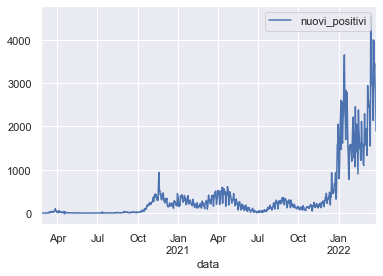

In [28]:
# get regional COVID-19 data
df = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-regioni/'
    'dpc-covid19-ita-regioni.csv',
    parse_dates=['data'], index_col='data'
)

df = df[df.denominazione_regione=="Calabria"]
df.index = df.index.normalize()
df.plot(y="nuovi_positivi");

In [29]:
# time series
ts = df[['nuovi_positivi']].dropna()
ts.loc[ts.nuovi_positivi<=0, "nuovi_positivi"] = np.nan
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 763 entries, 2020-02-24 to 2022-03-27
Freq: D
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   nuovi_positivi  709 non-null    float64
dtypes: float64(1)
memory usage: 11.9 KB


In [30]:
sts = ts.nuovi_positivi
sts.index.name = None

In [31]:
# Box-Cox Transformation
box_cox = BoxCox()
y_box_cox, lmbda = box_cox.transform_boxcox(ts)
ts_box_cox = ts.copy(deep=True)
ts_box_cox['nuovi_positivi'] = y_box_cox
ts_box_cox.fillna(0, inplace=True)

# SARIMAX

In [32]:
# SARIMAX grid-search
auto_sarima = pa.auto_arima(
    ts_box_cox,
    # ARIMA parameters
    d=1,
    # Seasonal parameters
    seasonal=True, m=7,
    # settings
    information_criterion='bic',
    trace=True,
    maxiter=200,
    suppress_warnings=True,
    alpha=.01,
    with_intercept=False,
    enforce_stationarity=False, 
    enforce_invertibility=False,
)
auto_sarima_boxcox_params = auto_sarima.get_params()

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1784.164, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=2160.673, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1977.417, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1899.798, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1915.341, Time=0.22 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1883.165, Time=0.21 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1778.297, Time=2.81 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1853.497, Time=0.40 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=4.62 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1788.172, Time=1.96 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1772.637, Time=1.40 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1766.588, Time=0.75 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1908.643, Time=0.12 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1876.539, Time=0.13 sec
 ARIMA(1,1,2)(1,0,2)[7]             : 

In [33]:
# SARIMAX best model
auto_sarima_boxcox_params.update({
    'enforce_stationarity': False
})
auto_sarima_boxcox_params

{'maxiter': 200,
 'method': 'lbfgs',
 'order': (0, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 1, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False,
 'enforce_stationarity': False}

In [34]:
# run SARIMAX model
sarimax = SARIMAX(
    ts_box_cox,
    **auto_sarima_boxcox_params,
    
).fit(
    maxiter=200,
    enforce_invertibility=False,
)

# Predictions

In [35]:
# predictions

alpha = .1
CI_lo = alpha / 2
CI_hi = 1 - CI_lo
CI = 1 - alpha

alpha2 = .5
CI_lo2 = alpha2 / 2
CI_hi2 = 1 - CI_lo2
CI2 = 1 - alpha2

predict_future_df_t_lo = sarimax.get_forecast(14).summary_frame(alpha=.5)
predict_future_df_t_hi = sarimax.get_forecast(14).summary_frame(alpha=.1)

predict_future_df_lo = predict_future_df_t_lo.copy(deep=True)
predict_future_df_hi = predict_future_df_t_hi.copy(deep=True)

for col in predict_future_df_lo.columns:
    predict_future_df_lo[col] = box_cox.untransform_boxcox(predict_future_df_lo[col], lmbda)
for col in predict_future_df_hi.columns:
    predict_future_df_hi[col] = box_cox.untransform_boxcox(predict_future_df_hi[col], lmbda)

predict_future = pd.DataFrame(
    index=predict_future_df_lo.index,
    columns = ['mu', 'lo', 'hi', 'lo2', 'hi2']
)
predict_future['mu'] = predict_future_df_lo['mean']
predict_future['lo'] = predict_future_df_hi['mean_ci_lower']
predict_future['hi'] = predict_future_df_hi['mean_ci_upper']
predict_future['lo2'] = predict_future_df_lo['mean_ci_lower']
predict_future['hi2'] = predict_future_df_lo['mean_ci_upper']

predict_past = sarimax.get_prediction().summary_frame(alpha=.1)[1:]
for col in predict_past.columns:
    predict_past[col] = box_cox.untransform_boxcox(predict_past[col], lmbda)
predict_past.drop('mean_se', axis=1, inplace=True)
predict_past.columns = ['mu', 'lo', 'hi']

/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/transform.py:101: RuntimeWarning: invalid value encountered in power
  y = np.power(lmbda * x + 1, 1. / lmbda)


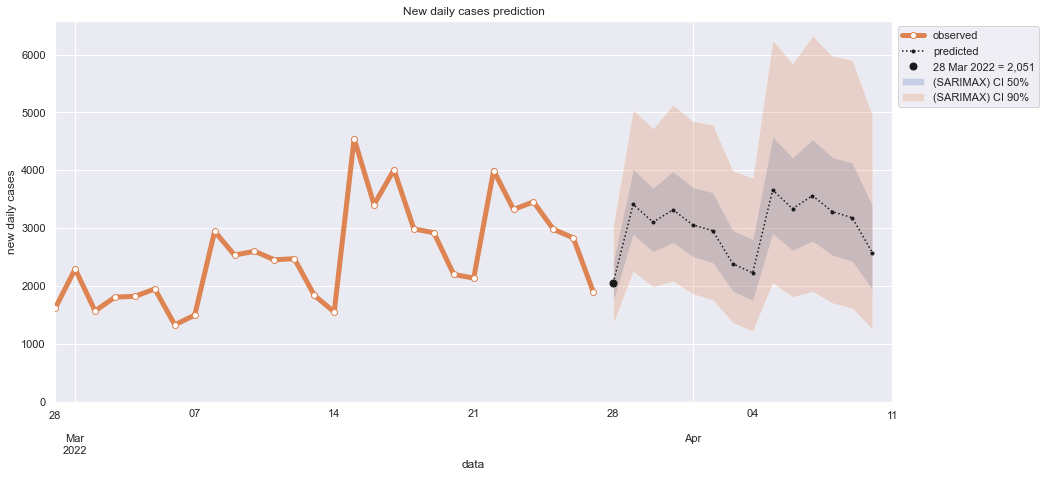

In [85]:
ax = df.iloc[-28:].nuovi_positivi.plot(
    lw=5, marker='o', mfc='w',
    label='observed', figsize=(15, 7), zorder=100, color='C1'
)
ax.plot(predict_future.index, predict_future.mu, color='k', ls=':', marker='.', label='predicted')
ax.plot(
    predict_future.index[0], predict_future.mu[0], marker='o', ms=7, ls='none', color='k', 
    label=f"{predict_future.index[0].date().strftime('%d %b %Y')} = {predict_future.mu[0]:,.0f}")
ax.fill_between(
    predict_future.index, predict_future.lo2, predict_future.hi2,
    alpha=.25, label=f'(SARIMAX) CI {CI2:.0%}'
)
ax.fill_between(
    predict_future.index, predict_future.lo, predict_future.hi,
    alpha=.25, label=f'(SARIMAX) CI {CI:.0%}'
)


ax.set_xlim(ax.get_xlim()[0], predict_future.index[-1] + pd.Timedelta(days=1))
ax.set(
    title=f'New daily cases prediction',
    ylabel='new daily cases',
    ylim=(0, ax.get_ylim()[1])
)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

fname = "predictions1"
plt.savefig(
    f"{fname}.pdf",
    bbox_inches="tight", 
    #pad_inches=0.5
)
plt.savefig(
    f"{fname}.svg",
    bbox_inches="tight", 
    #pad_inches=0.5
)
plt.savefig(
    f"{fname}.png",
    bbox_inches="tight", 
    #pad_inches=0.5
)
plt.show()

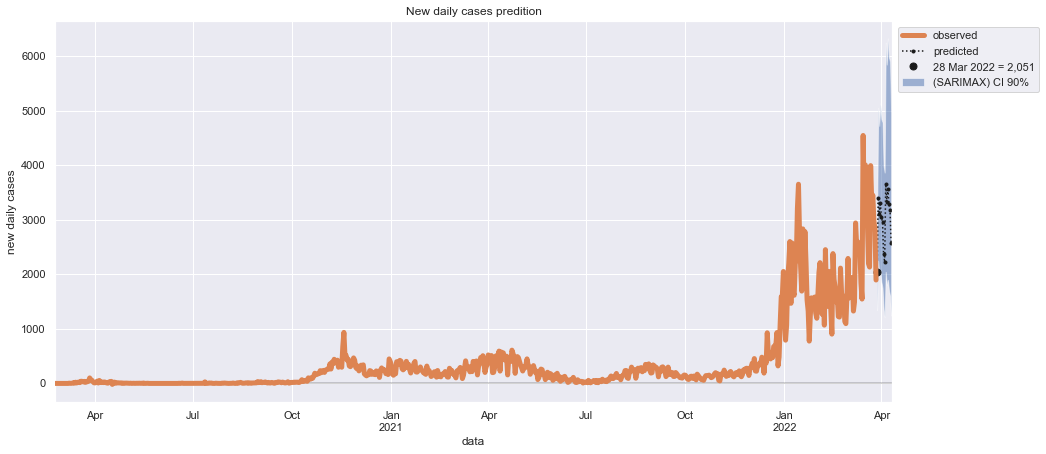

In [43]:
ax = df.nuovi_positivi.plot(
    lw=5, mfc='w',
    label='observed', figsize=(15, 7), zorder=100, color='C1'
)
ax.plot(predict_future.index, predict_future.mu, color='k', ls=':', marker='.', label='predicted')
ax.plot(
    predict_future.index[0], predict_future.mu[0], marker='o', ms=7, ls='none', color='k', 
    label=f"{predict_future.index[0].date().strftime('%d %b %Y')} = {predict_future.mu[0]:,.0f}")

ax.fill_between(
    predict_future.index, predict_future.lo, predict_future.hi,
    alpha=.5, label=f'(SARIMAX) CI {CI:.0%}'
)

ax.axhline(0, color="k", alpha=.25)
ax.set_xlim(ax.get_xlim()[0], predict_future.index[-1] + pd.Timedelta(days=1))
ax.set(
    title=f'New daily cases predition',
    ylabel='new daily cases',
)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

fname = "predictions2"
plt.savefig(
    f"{fname}.pdf",
    bbox_inches="tight", 
    #pad_inches=0.5
)
plt.savefig(
    f"{fname}.svg",
    bbox_inches="tight", 
    #pad_inches=0.5
)
plt.show()

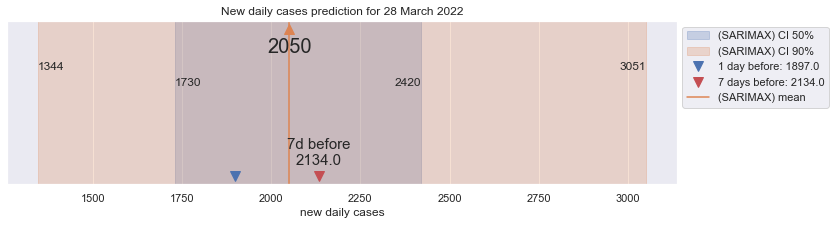

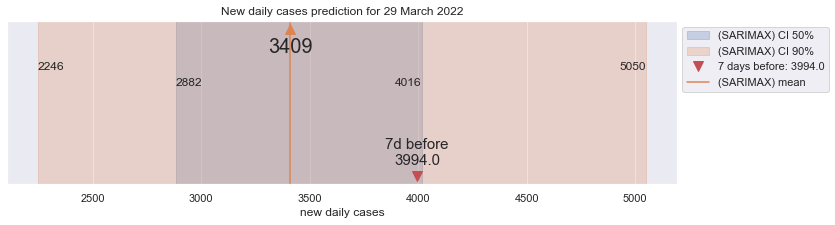

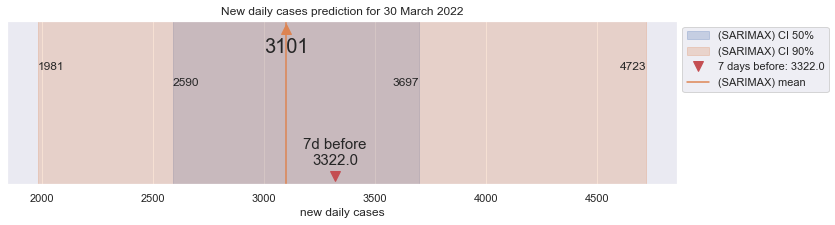

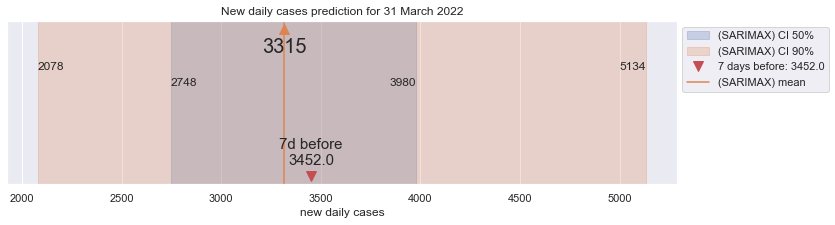

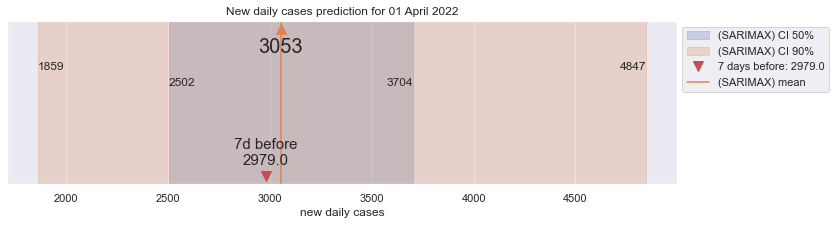

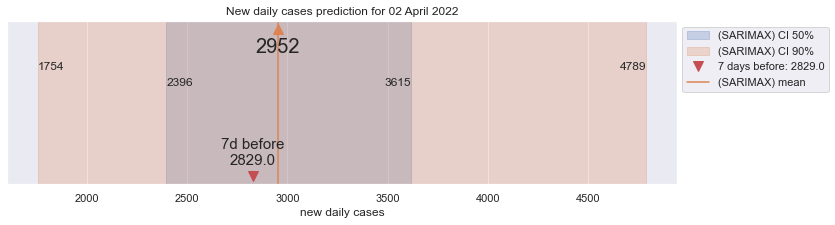

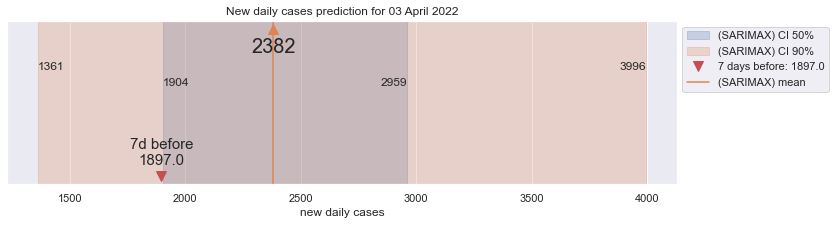

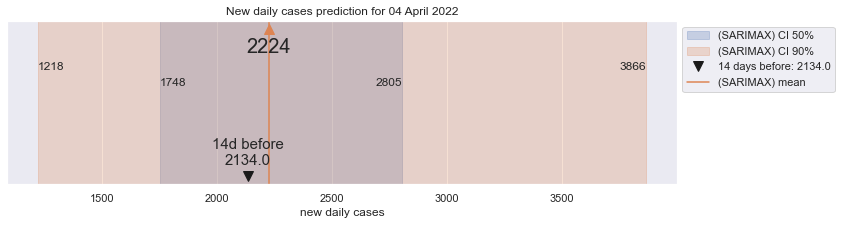

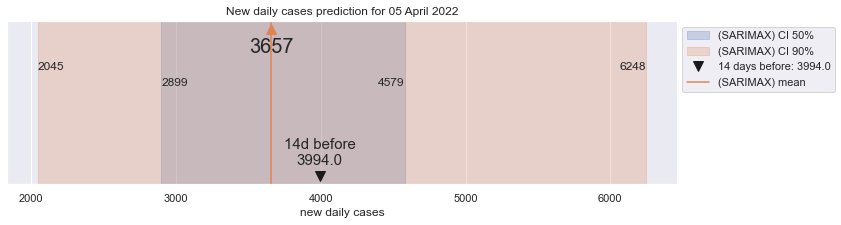

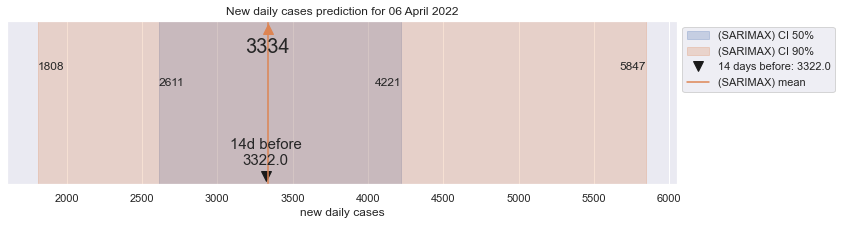

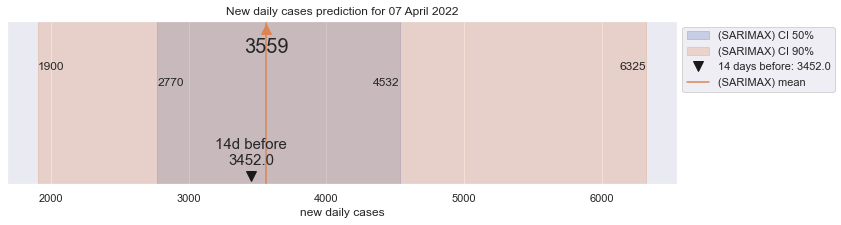

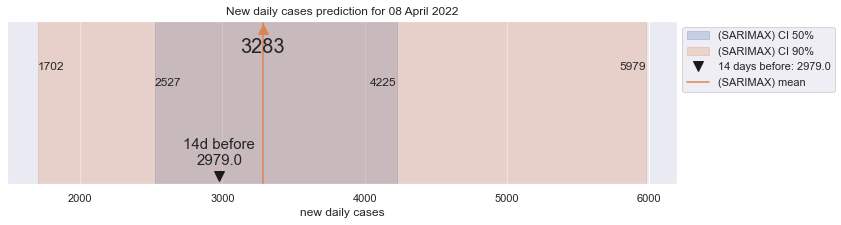

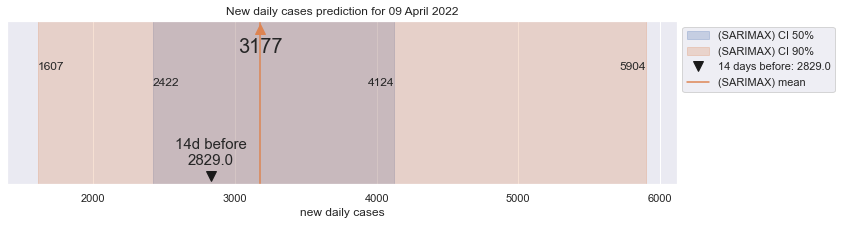

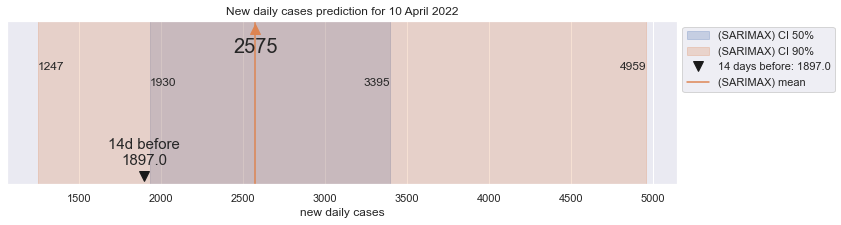

In [13]:
for i in range(predict_future.index.size):
    fig, ax = plt.subplots(figsize=(12, 3))

    ylim = ax.get_ylim()
    ax.fill_betweenx(
        [0, 1],
        predict_future.lo2[i], predict_future.hi2[i],
        alpha=.25, label=f'(SARIMAX) CI {CI2:.0%}',
        color='C0'
    )
    ax.fill_betweenx(
        [0, 1],
        predict_future.lo[i], predict_future.hi[i],
        alpha=.25, label=f'(SARIMAX) CI {CI:.0%}',
        color='C1'
    )
    #ax.plot(predict_future_x[:,i], predict_future_y[:,i], lw=1, ls='--', color='C1')
    if not i:
        ax.plot(ts.iloc[-1], .05, marker='v', color='C0', ls='none', 
                ms=10, label=f"1 day before: {ts.iloc[-1].values[0]}")
        #ax.text(
        #    ts.iloc[-1], .1,
        #    f"1g prima\n{ts.iloc[-1].values[0]}", 
        #    ha='center', va='bottom', fontsize=15
        #)
    if i < 7:
        ax.plot(ts.iloc[-7+i], .05, marker='v', color='r', ls='none', 
                ms=10, label=f"7 days before: {ts.iloc[-7+i].values[0]}")
        ax.text(
            ts.iloc[-7+i], .1,
            f"7d before\n{ts.iloc[-7+i].values[0]}", 
            ha='center', va='bottom', fontsize=15
        )
    else:
        ax.plot(ts.iloc[-14+i], .05, marker='v', color='k', ls='none', 
                ms=10, label=f"14 days before: {ts.iloc[-14+i].values[0]}")
        ax.text(
            ts.iloc[-14+i], .1,
            f"14d before\n{ts.iloc[-14+i].values[0]}", 
            ha='center', va='bottom', fontsize=15
        )

    ax.plot(predict_future.mu[i], .95, marker='^', color='C1', ls='none', ms=10)
    
    ax.text(predict_future.mu[i], .90, int(predict_future.mu[i]), ha='center', va='top', fontsize=20)
    
    ax.text(predict_future.lo[i], .75, int(predict_future.lo[i]), ha='left', va='top', fontsize=12)
    ax.text(predict_future.hi[i], .75, int(predict_future.hi[i]), ha='right', va='top', fontsize=12)
    
    ax.text(predict_future.lo2[i], .65, int(predict_future.lo2[i]), ha='left', va='top', fontsize=12)
    ax.text(predict_future.hi2[i], .65, int(predict_future.hi2[i]), ha='right', va='top', fontsize=12)
    
    ax.axvline(predict_future.mu[i], color='C1', label='(SARIMAX) mean')

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set(
        ylim=ylim, yticks=[],
        xlabel='new daily cases',
        title=f'New daily cases prediction for {predict_future.index[i].strftime("%d %B %Y")}',
    )
    plt.show()

# Diagnostics

In [48]:
def get_stationarity(ts, window, mdl, differentiate=False, fname="diagnostics"):
    #ts_orig = ts.copy(deep=True)
    if differentiate:
        ts = ts.diff().fillna(0)
    # rolling
    r_mu = ts.rolling(window=window, center=True).mean().dropna()
    r_sd = ts.rolling(window=window, center=True).std().dropna()
    r_va = ts.rolling(window=window, center=True).var().dropna()
    exog = ts.values.ravel().reshape(-1, 1)
    resid = mdl.resid
    
    # Breusch-Pagan test
    bp_test = sms.diagnostic.het_breuschpagan(resid, exog)
    # Seasonal decomposition
    sea = seasonal_decompose(ts)
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    
    fig = plt.figure(constrained_layout=True, figsize=(15, 7))
    gs = GridSpec(2, 4, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1:])
    ax30 = fig.add_subplot(gs[1, 0])
    ax31 = fig.add_subplot(gs[1, 1:3])
    ax33 = fig.add_subplot(gs[1, 3])

    mu_va = pd.DataFrame({'moving average': r_mu.values.ravel(), 'moving variance': r_va.values.ravel(),})
    sns.regplot(
        data=mu_va, x='moving average', y='moving variance',
        line_kws=dict(color='r'), scatter_kws=dict(alpha=.5),
        ax=ax1
    )
    ax1.set(
        title='7 days window',
        xlabel='moving average', ylabel='moving variance'
    )
    ts.plot(
        ax=ax2, label='observations', 
        title=f"Dickey-Fuller test $p$-value: {result[1]:.5f}"
    )
    r_mu.plot(ax=ax2, label='rolling mean')
    r_sd.plot(ax=ax2, label='rolling Std')
    ax2.legend()
    
    ax30.plot(exog, resid, marker='.', alpha=.5, ls='none')
    bp_text = f"{bp_test[-1]:.6f}" if bp_test[-1] > .01 else f"{bp_test[-1]:.6e}"
    ax30.set(
        title=f'Breusch-Pagan $p$-value: {bp_text}',
        xlabel='observations', ylabel='SARIMA residuals'
    )
    
    sea.trend.plot(ax=ax31, title='trend')
    sea.seasonal.plot(ax=ax33, xlim=(sea.seasonal.index[0], sea.seasonal.index[7*4]), title='seasonality')
    
    plt.savefig(
        f"{fname}.pdf",
        bbox_inches="tight", 
        #pad_inches=0.5
    )
    plt.savefig(
        f"{fname}.svg",
        bbox_inches="tight", 
        #pad_inches=0.5
    )
    plt.show()

In [82]:
def get_stationarity2(
    ts1, window1, mdl1,
    ts2, window2, mdl2,
    differentiate1=False, differentiate2=False, 
    fname="diagnostics"):
    
    def calculations(ts, window, mdl, differentiate):
        if differentiate:
            ts = ts.diff().fillna(0)
        # rolling
        r_mu = ts.rolling(window=window, center=True).mean().dropna()
        r_sd = ts.rolling(window=window, center=True).std().dropna()
        r_va = ts.rolling(window=window, center=True).var().dropna()
        exog = ts.values.ravel().reshape(-1, 1)
        resid = mdl.resid
        # Breusch-Pagan test
        bp_test = sms.diagnostic.het_breuschpagan(resid, exog)
        # Seasonal decomposition
        sea = seasonal_decompose(ts)
        # Dickey-Fuller test
        result = adfuller(ts, autolag='AIC')
        return r_mu, r_sd, r_va, exog, resid, bp_test, sea, result, ts
    
    def plot_results(
        ax1, ax2, ax30, ax31, ax33,
        r_mu, r_sd, r_va, exog, resid, bp_test, sea, result, ts
    ):
        mu_va = pd.DataFrame({'moving average': r_mu.values.ravel(), 'moving variance': r_va.values.ravel(),})
        sns.regplot(
            data=mu_va, x='moving average', y='moving variance',
            line_kws=dict(color='r'), scatter_kws=dict(alpha=.5),
            ax=ax1
        )
        ax1.set(
            title='7 days window',
            xlabel='moving average', ylabel='moving variance'
        )
        ts.plot(
            ax=ax2, label='observations', 
            title=f"Dickey-Fuller test $p$-value: {result[1]:.5f}"
        )
        r_mu.plot(ax=ax2, label='rolling mean')
        r_sd.plot(ax=ax2, label='rolling Std')
        ax2.get_legend().remove()

        ax30.plot(exog, resid, marker='.', alpha=.5, ls='none')
        bp_text = f"{bp_test[-1]:.6f}" if bp_test[-1] > .01 else f"{bp_test[-1]:.6e}"
        ax30.set(
            title=f'Breusch-Pagan $p$-value: {bp_text}',
            xlabel='observations', ylabel='SARIMA residuals'
        )

        sea.trend.plot(ax=ax31, title='trend')
        sea.seasonal.plot(ax=ax33, xlim=(sea.seasonal.index[0], sea.seasonal.index[7*4]), title='seasonality')
    
    r_mu1, r_sd1, r_va1, exog1, resid1, bp_test1, sea1, result1, ts1 = calculations(ts1, window1, mdl1, differentiate1)
    r_mu2, r_sd2, r_va2, exog2, resid2, bp_test2, sea2, result2, ts2 = calculations(ts2, window2, mdl2, differentiate2)
    
    fig = plt.figure(constrained_layout=True, figsize=(15, 15))
    gs = GridSpec(4, 4, figure=fig)
    ax1A = fig.add_subplot(gs[0, 0])
    ax1B = fig.add_subplot(gs[0, 1:])
    ax1C = fig.add_subplot(gs[1, 0])
    ax1D = fig.add_subplot(gs[1, 1:3])
    ax1E = fig.add_subplot(gs[1, 3])
    ax2A = fig.add_subplot(gs[2, 0])
    ax2B = fig.add_subplot(gs[2, 1:])
    ax2C = fig.add_subplot(gs[3, 0])
    ax2D = fig.add_subplot(gs[3, 1:3])
    ax2E = fig.add_subplot(gs[3, 3])

    plot_results(
        ax1A, ax1B, ax1C, ax1D, ax1E,
        r_mu1, r_sd1, r_va1, exog1, resid1, bp_test1, sea1, result1, ts1
    )
    
    plot_results(
        ax2A, ax2B, ax2C, ax2D, ax2E,
        r_mu2, r_sd2, r_va2, exog2, resid2, bp_test2, sea2, result2, ts2
    )
    
    plt.figtext(0, .75, "A.", fontsize=20)
    plt.figtext(0, .25, "B.", fontsize=20)
    
    plt.savefig(
        f"{fname}.pdf",
        bbox_inches="tight", 
        #pad_inches=0.5
    )
    plt.savefig(
        f"{fname}.svg",
        bbox_inches="tight", 
        #pad_inches=0.5
    )
    plt.savefig(
        f"{fname}.png",
        bbox_inches="tight", 
        #pad_inches=0.5
    )
    plt.show()

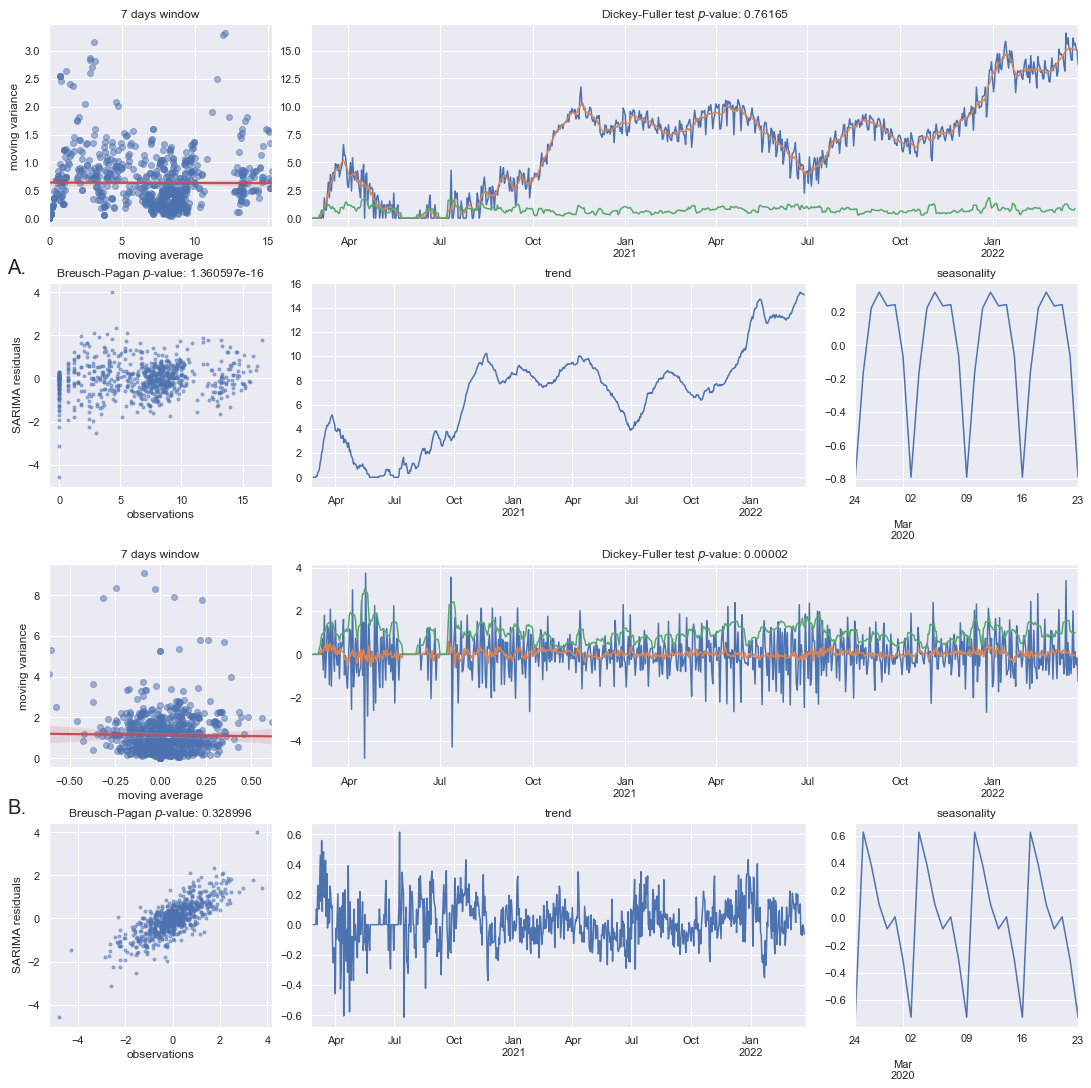

In [83]:
get_stationarity2(
    ts_box_cox.fillna(0), 7, sarimax,
    ts_box_cox.fillna(0), 7, sarimax,
    differentiate1=False, differentiate2=True,
    fname="diagnostics",
)

Box-Cox transformed data:

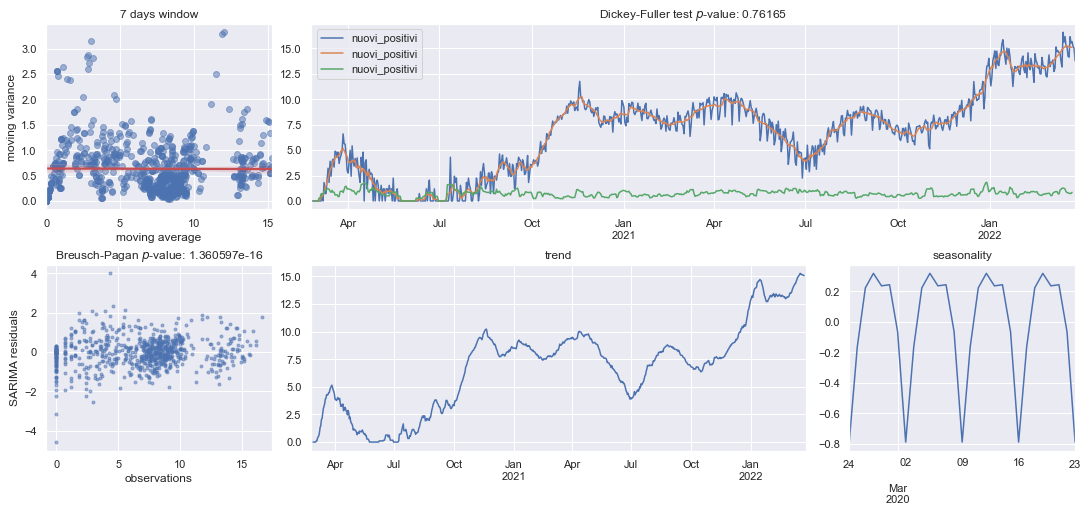

In [46]:
get_stationarity(ts_box_cox.fillna(0), 7, sarimax, fname="diagnostics1")

Prime derivative of Box-Cox transformed data:

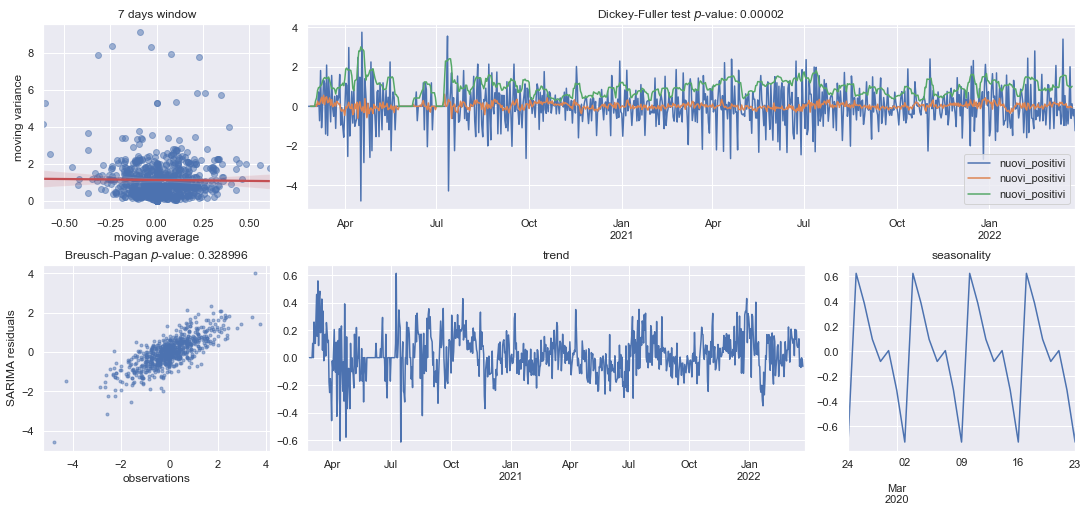

In [47]:
get_stationarity(ts_box_cox, 7, sarimax, differentiate=True, fname="diagnostics2")

In [49]:
def welch_analysis(df, fd=None, period=4, denom=4,
                   significative=[1],
                   max_xlim=1.95, fs=1.0,
                   nharmonics=0, nfft=2**16,
                   sample_rate='daily', basis='hours',
                   title='Sample',
                   min_harm_mode=2, hertz=False,
                   harm_rot=0, fname="periodogram"
                   ):

    if fd is None:
        fd = df.diff()[1:]

    _f, _p = periodogram(
        fd.values.ravel(),
        fs=fs,
        detrend='linear', 
        nfft=nfft, 
        scaling='density'
    )
    
    periods = 1 / _f[1:]
    density = _p[1:] / _p[1:].max()
    
    fig, ax = plt.subplots(figsize=(15, 4))

    xlim=(max(period/(nharmonics+1), max_xlim), period*2)
    
    good_periods = periods[(periods>xlim[0])&(periods<xlim[1])]
    good_density = density[(periods>xlim[0])&(periods<xlim[1])]

    good_density /= good_density.max()
    ax.plot(good_periods, good_density, color='k', lw=1)
    ax.set(
        xlim=xlim,
        ylim=(-.05, 1.1),
        xscale='log', 
        xticks=[],  xticklabels=[], 
        title=f'{title}'
    )

    harmonics = period / np.arange(1, nharmonics+2, 1)
    for i, harm_mode in enumerate(harmonics[:-1]):
        if harm_mode < min_harm_mode:
            continue
        ax.text(
            harm_mode, -.05, 
            f"{harm_mode/denom:.1f}\n{i+1}°" if not hertz else f"{1/(harm_mode/denom):.1f}\n{i+1}°",
            ha='center', va='top',
            rotation=harm_rot
        )
        ax.axvline(harm_mode, color='r', ls='--')

    plt.savefig(
        f"{fname}.pdf",
        bbox_inches="tight", 
        #pad_inches=0.5
    )
    plt.savefig(
        f"{fname}.svg",
        bbox_inches="tight", 
        #pad_inches=0.5
    )
    plt.show()

Periodogram:

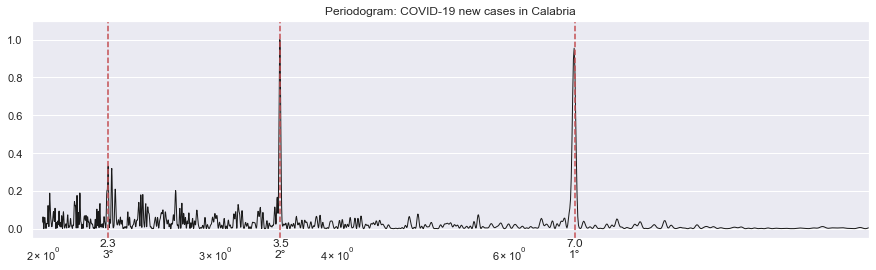

In [50]:
test_it_harm = welch_analysis(
    ts_box_cox.fillna(0), period=7, denom=1,
    nfft=2**12,
    significative=[2, 3, 4, 5, 6, 8, 9, 10, 11, 12],
    nharmonics=12, 
    title="Periodogram: COVID-19 new cases in Calabria",
)

In [19]:
# SARIMAX model summary
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                    nuovi_positivi   No. Observations:                  763
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -863.868
Date:                           Sun, 27 Mar 2022   AIC                           1735.736
Time:                                   22:16:36   BIC                           1754.232
Sample:                               02-24-2020   HQIC                          1742.861
                                    - 03-27-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6348      0.024    -26.457      0.000      -0.682      -0.588
ar.S.L7        0.9896      0.010     97.851      0.000       0.970       1.009
ma.S.L7       -0.8780      0.026    -33.298      0.000      -0.930      -0.826
sigma2         0.5731      0.020     29.319      0.000       0.535       0.611
===================================================================================
Ljung-Box (Q):                       49.26   Jarque-Bera (JB):               258.22
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

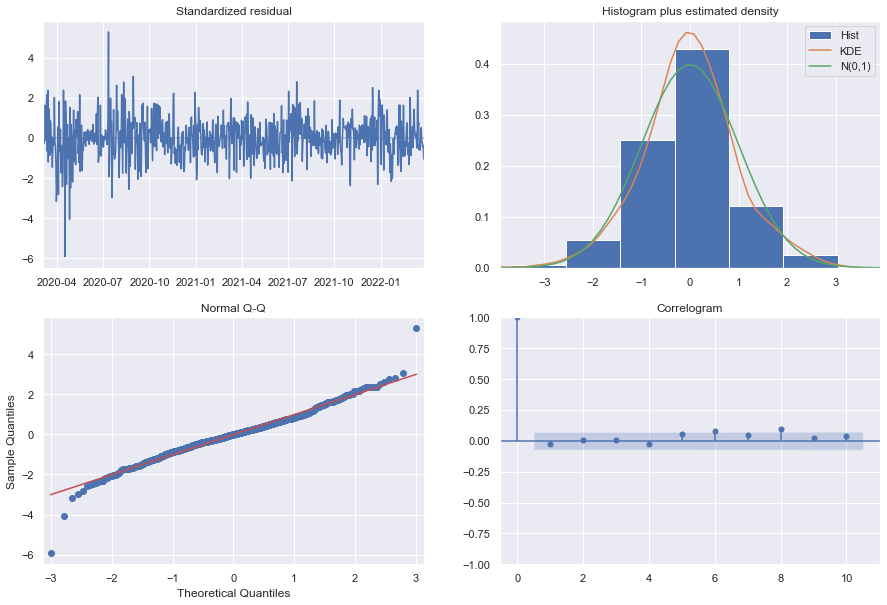

In [54]:
# SARIMAX model diagnostics
ax = sarimax.plot_diagnostics(figsize=(15,10))

fname = "sarima_diagnostics"
ax.savefig(
    f"{fname}.pdf",
    bbox_inches="tight", 
    #pad_inches=0.5
)
ax.savefig(
    f"{fname}.svg",
    bbox_inches="tight", 
    #pad_inches=0.5
)
plt.show()

In [55]:
dir(ax)

['_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_axes_internal',
 '_agg_filter',
 '_align_label_groups',
 '_alpha',
 '_animated',
 '_axobservers',
 '_axstack',
 '_button_pick_id',
 '_cachedRenderer',
 '_callbacks',
 '_canvas_callbacks',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_constrained',
 '_constrained_layout_pads',
 '_default_contains',
 '_dpi',
 '_gci',
 '_get_clipping_extent_bbox',
 '_get_dpi',
 '_get_draw_artists',
 '_gid',
 '_gridspecs',
 '_in_layout',
 '_label',
 '_localaxes',
 '_mouseover',
 '_normalize_grid_string',
 '_original_dpi',
 '_path_effects',
 '_picker',
 '_process_projection_r

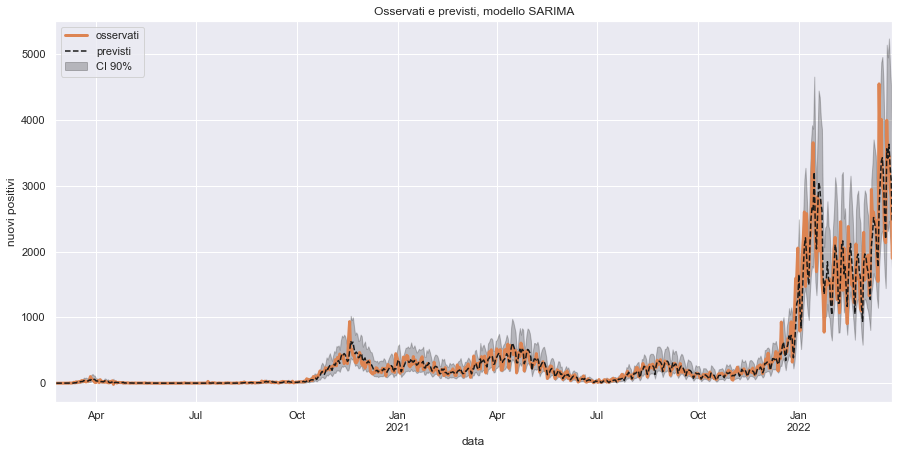

In [56]:
# Full predictions
fig, ax = plt.subplots(figsize=(15, 7))
df.nuovi_positivi.plot(ax=ax, lw=3, label='osservati', color='C1')
ax.plot(
    predict_past.index, predict_past.mu,
    ls='--', zorder=100,
    color='k', label='previsti',
)
ax.fill_between(
    predict_past.index,
    predict_past.lo, predict_past.hi,
    alpha=.25, color='k', label=f"CI {CI:.0%}"
)
ax.legend(loc='upper left')
ax.set(
    title='Osservati e previsti, modello SARIMA',
    ylabel='nuovi positivi'
)
plt.show()

In [57]:
sarimax_R2 = r2_score(ts.nuovi_positivi.fillna(0).values[1:], predict_past.fillna(0).mu)

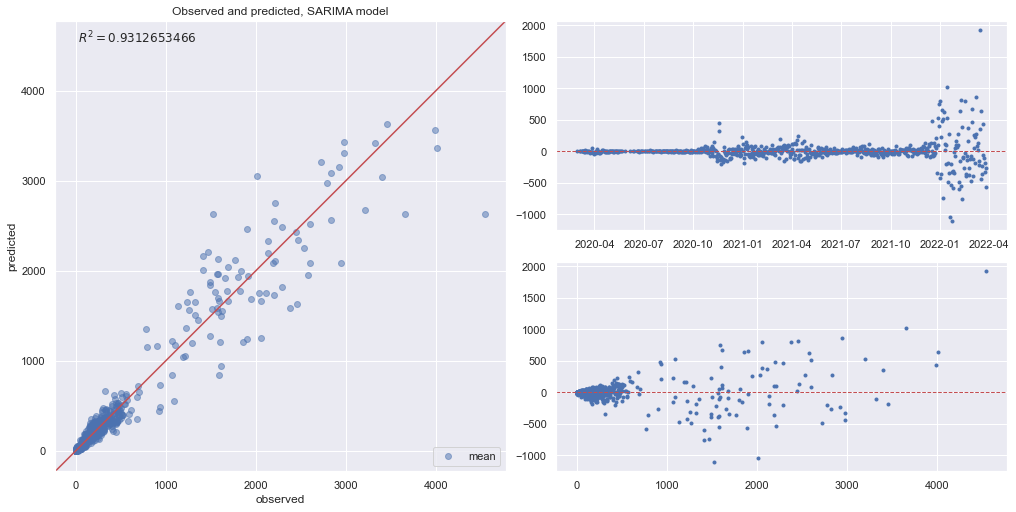

In [58]:
fig = plt.figure(constrained_layout=True, figsize=(14, 7))

gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(
    ts.nuovi_positivi.values[1:], predict_past.mu,
    marker='o', ls='none', alpha=.5, label='mean'
)

ax1.axline(xy1=(0, 0), slope=1, color='r')
ax1.text(
    .05, .95,
    f"$R^2 = {sarimax_R2:.10f}$",
    transform=ax1.transAxes
)
ax1min = min(ax1.get_xlim()[0], ax1.get_ylim()[0])
ax1max = max(ax1.get_xlim()[1], ax1.get_ylim()[1])
ax1.set(
    xlabel='observed',
    ylabel='predicted',
    title='Observed and predicted, SARIMA model',
    xlim=(ax1min, ax1max),
    ylim=(ax1min, ax1max),
)

ax2.plot(ts.nuovi_positivi.index[1:], ts.nuovi_positivi.values[1:] - predict_past.mu, ls='none', marker='.')
ax2.axhline(0, color='r', lw=1, ls='--')

ax3.plot(ts.nuovi_positivi.values[1:], ts.nuovi_positivi.values[1:] - predict_past.mu, ls='none', marker='.')
ax3.axhline(0, color='r', lw=1, ls='--')

ax1.legend(loc='lower right')

plt.show()

# TEST

In [59]:
min_dt = pd.to_datetime("2021-01-01")
max_dt = ts_box_cox.index.max()-pd.Timedelta(days=14)

In [90]:
min_dt

Timestamp('2021-01-01 00:00:00')

In [91]:
max_dt

Timestamp('2022-03-13 00:00:00', freq='D')

In [60]:
observed = np.array([])
forecasted = []

for day in tqdm(ts_box_cox.index):
    if day < min_dt or day > max_dt:
        continue
    partial_ts = ts_box_cox[ts_box_cox.index<=day]
    future_ts = ts[
        (ts_box_cox.index>day)
        &
        (ts_box_cox.index<=day+pd.Timedelta(days=14))
    ]
    
    # SARIMAX grid-search
    partial_auto_sarima = pa.auto_arima(
        partial_ts,
        # ARIMA parameters
        d=1,
        # Seasonal parameters
        seasonal=True, m=7,
        # settings
        information_criterion='bic',
        trace=True,
        maxiter=200,
        suppress_warnings=True,
        alpha=.01,
        with_intercept=False,
        enforce_stationarity=False, 
        enforce_invertibility=False,
    )
    partial_auto_sarima_boxcox_params = partial_auto_sarima.get_params()
    partial_auto_sarima_boxcox_params.update({
        'enforce_stationarity': False
    })

    # run SARIMAX model
    partial_sarimax = SARIMAX(
        partial_ts,
        **partial_auto_sarima_boxcox_params,

    ).fit(
        maxiter=200,
        enforce_invertibility=False,
    )
    
    # forecast
    box_cox_forecast = partial_sarimax.get_forecast(14).summary_frame()['mean'].values
    partial_forecast = box_cox.untransform_boxcox(box_cox_forecast, lmbda)
    
    observed = np.concatenate((observed, future_ts.nuovi_positivi.values))
    forecasted = np.concatenate((forecasted, partial_forecast))

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=915.771, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=861.739, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=822.101, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=818.614, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=822.014, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[7]             : BIC=824.353, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[7]             : BIC=824.353, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7]             : BIC=856.992, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=829.927, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : BIC=821.871, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[7]          
Total fit time: 1.331 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=0.89 sec
 ARI

 ARIMA(1,1,1)(0,0,0)[7]             : BIC=848.011, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[7]             : BIC=848.005, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7]             : BIC=880.809, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=853.520, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : BIC=845.456, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[7]          
Total fit time: 0.487 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=869.527, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=942.208, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=888.051, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=847.396, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=844.601, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=847.272, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[7]             : BIC=850.328, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[7]             : B

 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=962.765, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=906.825, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=864.899, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=862.404, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=864.731, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[7]             : BIC=868.127, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[7]             : BIC=868.115, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7]             : BIC=902.655, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=873.626, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : BIC=865.984, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[7]          
Total fit time: 1.259 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=964.8

 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[7]             : BIC=885.984, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[7]             : BIC=885.965, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7]             : BIC=921.997, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=891.456, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : BIC=883.957, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[7]          
Total fit time: 1.931 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=985.016, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=928.067, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=884.394, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=882.009, Time=0.02 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=884.200, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[7]             : BIC=887.7

 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1006.250, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=946.979, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=902.814, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=900.833, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=902.520, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[7]             : BIC=906.542, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[7]             : BIC=906.521, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7]             : BIC=943.069, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=912.061, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : BIC=905.060, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[7]          
Total fit time: 1.232 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1008

 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[7]             : BIC=924.654, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[7]             : BIC=924.635, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7]             : BIC=963.363, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=930.207, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : BIC=923.226, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[7]          
Total fit time: 1.294 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1030.336, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=968.859, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=922.243, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=920.487, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=921.903, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[7]             : BIC=926.

 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1052.634, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=989.401, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=941.159, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=939.932, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=940.777, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[7]             : BIC=945.655, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[7]             : BIC=945.628, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7]             : BIC=986.054, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=951.230, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : BIC=944.036, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[7]          
Total fit time: 1.249 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=1.41 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1054

 ARIMA(0,1,1)(1,0,0)[7] intercept   : BIC=961.628, Time=0.11 sec

Best model:  ARIMA(0,1,1)(1,0,0)[7]          
Total fit time: 2.662 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1077.080, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1013.948, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=964.824, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=964.621, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=964.208, Time=0.04 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=969.276, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.33 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(1,0,0)[7]             : BIC=1082.707, Time=0.02 sec
 ARIMA(1,1,1)(1,0,0)[7]             : BIC=970.002, Time=0.05 sec
 ARIMA(0,1,2)(1,0,0)[7]             : BIC=969.987, Time=0.04 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=97

 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.93 sec
 ARIMA(0,1,0)(1,0,0)[7]             : BIC=1100.442, Time=0.03 sec
 ARIMA(1,1,1)(1,0,0)[7]             : BIC=986.019, Time=0.04 sec
 ARIMA(0,1,2)(1,0,0)[7]             : BIC=985.984, Time=0.04 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=991.654, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : BIC=984.569, Time=0.07 sec

Best model:  ARIMA(0,1,1)(1,0,0)[7]          
Total fit time: 2.667 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1097.519, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1034.370, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=983.012, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=983.941, Time=0.01 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.33 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=987.647, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=98

 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.37 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1004.990, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=999.983, Time=0.03 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1004.286, Time=0.06 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(1,0,0)[7]             : BIC=1125.583, Time=0.03 sec
 ARIMA(1,1,1)(1,0,0)[7]             : BIC=1005.725, Time=0.05 sec
 ARIMA(0,1,2)(1,0,0)[7]             : BIC=1005.702, Time=0.04 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1011.421, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : BIC=1004.146, Time=0.08 sec

Best model:  ARIMA(0,1,1)(1,0,0)[7]          
Total fit time: 3.081 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1122.342, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1056.350, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : 

 ARIMA(0,1,1)(1,0,0)[7] intercept   : BIC=1019.301, Time=0.07 sec

Best model:  ARIMA(0,1,1)(1,0,0)[7]          
Total fit time: 2.844 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1139.376, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1072.044, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1018.133, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1021.208, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.38 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1021.654, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1016.676, Time=0.03 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1020.554, Time=0.06 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=1.09 sec
 ARIMA(0,1,0)(1,0,0)[7]             : BIC=1144.073, Time=0.02 sec
 ARIMA(1,1,1)(1,0,0)[7]             : BIC=1022.303, Time=0.04 sec
 ARIMA(0,1,2)(1,0,0)[7]             :

/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,1,2)(1,0,1)[7]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,

 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1145.936, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1078.374, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1024.409, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1027.949, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.43 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1027.735, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1022.804, Time=0.04 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1026.437, Time=0.07 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=1.26 sec
 ARIMA(0,1,0)(1,0,0)[7]             : BIC=1150.557, Time=0.02 sec
 ARIMA(1,1,1)(1,0,0)[7]             : BIC=1028.373, Time=0.06 sec
 ARIMA(0,1,2)(1,0,0)[7]             : BIC=1028.334, Time=0.03 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1034.098, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : BIC=1026.703, Time=0.06 sec

Best model:  ARIMA(0,1,1)

 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(1,0,0)[7]             : BIC=1170.283, Time=0.03 sec
 ARIMA(1,1,1)(1,0,0)[7]             : BIC=1047.494, Time=0.04 sec
 ARIMA(0,1,2)(1,0,0)[7]             : BIC=1047.434, Time=0.04 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1053.251, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : BIC=1046.234, Time=0.08 sec

Best model:  ARIMA(0,1,1)(1,0,0)[7]          
Total fit time: 2.026 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1168.314, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1100.926, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1046.747, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1052.050, Time=0.01 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.23 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1049.206, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[7]             :

 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.19 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1065.448, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1060.862, Time=0.03 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1063.228, Time=0.07 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.82 sec
 ARIMA(0,1,0)(1,0,0)[7]             : BIC=1195.233, Time=0.03 sec
 ARIMA(1,1,1)(1,0,0)[7]             : BIC=1066.324, Time=0.04 sec
 ARIMA(0,1,2)(1,0,0)[7]             : BIC=1066.282, Time=0.04 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1072.143, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : BIC=1064.741, Time=0.08 sec

Best model:  ARIMA(0,1,1)(1,0,0)[7]          
Total fit time: 1.962 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1200.748, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1127.685, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             :

 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1225.579, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1147.718, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1090.234, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1100.340, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1090.773, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1086.349, Time=0.03 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1087.143, Time=0.07 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(1,0,0)[7]             : BIC=1226.017, Time=0.03 sec
 ARIMA(1,1,1)(1,0,0)[7]             : BIC=1091.816, Time=0.04 sec
 ARIMA(0,1,2)(1,0,0)[7]             : BIC=1091.778, Time=0.03 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1097.618, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : BIC=1090.619, Time=0.09 sec

Best model:  ARIMA(0,1,1

 ARIMA(0,1,2)(0,0,2)[7]             : BIC=1108.847, Time=0.11 sec
 ARIMA(1,1,0)(0,0,2)[7]             : BIC=1166.635, Time=0.07 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1114.726, Time=0.20 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : BIC=1107.991, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,2)[7]          
Total fit time: 2.424 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1245.021, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1163.974, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1105.121, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1116.078, Time=0.01 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.19 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1104.967, Time=0.09 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,0,2)[7]             : BIC=1249.262, Time=0.05 sec
 ARIMA(1,1,1)(0,0,2)[7]             :

 ARIMA(0,1,2)(0,0,2)[7]             : BIC=1124.272, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[7]             : BIC=1183.007, Time=0.07 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1130.195, Time=0.23 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : BIC=1123.681, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,2)[7]          
Total fit time: 2.333 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1263.496, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1181.223, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1121.546, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1133.041, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=inf, Time=0.19 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1120.473, Time=0.09 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,0,2)[7]             : BIC=1267.114, Time=0.06 sec
 ARIMA(1,1,1)(0,0,2)[7]             :

 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1115.915, Time=0.37 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 15.698 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1129.702, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1281.542, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1197.049, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1139.667, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1156.592, Time=0.12 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1151.619, Time=0.14 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=0.88 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=inf, Time=1.26 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1167.945, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1155.524, Time=0.36 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1150.590, Time=0.32 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=1.92 sec
 ARIMA(1,1,2)(1,0,1)[7]             

 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.95 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1122.332, Time=0.23 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1122.302, Time=0.34 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 17.118 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1135.540, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1289.616, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1206.790, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1147.241, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1163.753, Time=0.20 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1158.670, Time=0.15 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=1.50 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=inf, Time=1.02 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1175

 ARIMA(0,1,1)(1,0,2)[7]             : BIC=inf, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1164.129, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1148.957, Time=0.09 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1143.332, Time=0.08 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1127.615, Time=0.26 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1127.589, Time=0.37 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 20.021 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1141.825, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1298.980, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1214.624, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1155.389, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC

/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1143.313, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1301.671, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1216.331, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1156.960, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1173.471, Time=0.14 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1167.614, Time=0.15 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=1.11 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=inf, Time=0.77 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1187.188, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1171.581, Time=0.35 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1165.964, Time=0.32 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=2.14 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=inf, Time=0.68 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=1137.463, Time=0.26 sec
 ARIMA(2,1,1)(0,0,1)[7]             : BIC=1167.309, T

 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1135.056, Time=0.24 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1135.042, Time=0.45 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 19.979 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1150.193, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1310.134, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1225.089, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1163.869, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1180.236, Time=0.18 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1174.240, Time=0.14 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=0.85 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=inf, Time=0.89 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1194.343, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1178.036, Time=0.47 sec
 ARIMA(2,1,2)(2,0,0)[7]             

 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.87 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1141.684, Time=0.24 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1141.689, Time=0.48 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 19.122 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1155.462, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1319.997, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1233.818, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1172.198, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1188.575, Time=0.17 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1181.903, Time=0.24 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=1.10 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=inf, Time=1.25 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1203

 ARIMA(0,1,1)(1,0,2)[7]             : BIC=inf, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1194.457, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1172.745, Time=0.09 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1165.750, Time=0.07 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.85 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1147.752, Time=0.24 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1199.617, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1147.773, Time=0.39 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 20.636 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1161.479, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1328.726, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1241.158, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1178.472, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[7]             

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1169.512, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1339.921, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1250.163, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1187.377, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1204.148, Time=0.17 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1197.305, Time=0.17 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=1.61 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=inf, Time=1.26 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1219.075, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1196.331, Time=0.84 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1193.659, Time=0.40 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=2.43 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1156.805, Time=0.67 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1198.000, Time=0.13 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1191.1

 ARIMA(1,1,2)(2,0,1)[7]             : BIC=inf, Time=1.39 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=inf, Time=1.98 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1224.689, Time=0.06 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1202.971, Time=0.35 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1195.019, Time=0.19 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.54 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1163.034, Time=0.20 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1163.049, Time=0.25 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1167.536, Time=0.52 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1157.080, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1188.479, Time=0.03 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=1161.030, Time=0.44 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=1161.149, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1215.394, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1191.619, Time=0.09 sec
 ARIMA(0,1,1)(2,0,0)[7]  

 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.99 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1220.596, Time=0.19 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1168.755, Time=0.34 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 17.224 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1182.040, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1362.211, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1266.421, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1203.774, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1220.751, Time=0.17 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1212.834, Time=0.18 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1185.968, Time=1.39 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1186.075, Time=1.53 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1238.275, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[7]        

 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1228.106, Time=0.53 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1218.766, Time=0.16 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=2.66 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1177.005, Time=0.80 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1227.461, Time=0.06 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1218.322, Time=0.12 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1182.581, Time=1.34 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=1182.578, Time=1.70 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1247.569, Time=0.05 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1221.937, Time=0.15 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1212.536, Time=0.22 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.54 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1177.759, Time=0.22 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1177.775, Time=0.29 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1182.251, Time=0.58 sec
 ARIMA(0,1,1)(1,0,1)

 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1214.266, Time=0.04 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=1182.209, Time=0.43 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=1182.290, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1245.708, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1218.237, Time=0.14 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1208.353, Time=0.12 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=1.36 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=1343.483, Time=0.13 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1236.049, Time=0.18 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1184.476, Time=0.38 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 18.912 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1198.130, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1385.351, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1287.528, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]   

 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1254.460, Time=0.22 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1243.908, Time=0.19 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1210.939, Time=0.83 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1211.010, Time=0.92 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1277.191, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1248.642, Time=0.21 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1238.036, Time=0.16 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=2.53 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1194.056, Time=0.64 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1248.325, Time=0.06 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1237.986, Time=0.06 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1199.542, Time=1.51 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=1199.532, Time=1.91 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1271.376, Time=0.04 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1242.360, Time=0.14 sec
 ARIMA(1,1,2)(2

 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1237.339, Time=0.22 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=1.82 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1200.431, Time=0.23 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1200.444, Time=0.19 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1204.799, Time=0.66 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1194.469, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1232.687, Time=0.03 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=1198.395, Time=0.38 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=1198.476, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1268.805, Time=0.01 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1236.979, Time=0.11 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1225.508, Time=0.09 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=1.13 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=1364.061, Time=0.11 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1253.323, Time=0.14 sec
 ARIMA(0,1,1)(1,0,1)

 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1207.028, Time=0.50 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 18.761 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1220.202, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1423.164, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1318.371, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1256.754, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1273.280, Time=0.16 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1261.535, Time=0.15 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1224.754, Time=1.97 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1225.195, Time=0.96 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1297.865, Time=0.06 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1266.145, Time=0.44 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1253.946, Time=0.41 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=1.73 sec
 ARIMA(1,1,2)(1,0,1)[7]   

 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1218.648, Time=0.63 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1278.018, Time=0.10 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1266.337, Time=0.12 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1224.303, Time=1.45 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=1224.307, Time=1.71 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1302.013, Time=0.04 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1269.604, Time=0.28 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1257.472, Time=0.26 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.54 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1219.767, Time=0.20 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1219.790, Time=0.19 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1224.213, Time=0.60 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1214.016, Time=0.30 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1254.634, Time=0.04 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=1218.056, Time=0.38 sec
 ARIMA(0,1,1)(1

 ARIMA(0,1,1)(1,0,2)[7]             : BIC=1223.078, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1300.786, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1263.486, Time=0.10 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1250.470, Time=0.09 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=1396.630, Time=0.12 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1279.002, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1225.306, Time=0.42 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 23.087 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1231.230, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1448.192, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1338.641, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1275.578, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1283.980, Time=0.30 sec
 ARIMA(2,1,2)(1,0,0)[7]   

 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1288.269, Time=0.32 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1246.955, Time=2.45 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1246.953, Time=2.79 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1307.603, Time=0.14 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1291.102, Time=0.66 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1283.284, Time=0.19 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=3.62 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1235.452, Time=0.62 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1297.797, Time=0.10 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1286.372, Time=0.10 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1241.344, Time=1.56 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=1241.342, Time=1.83 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1321.221, Time=0.04 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1289.122, Time=0.23 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1277.054, Time=0.23 sec
 ARIMA(1,1,2)(2

 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.82 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1244.569, Time=0.22 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1244.598, Time=0.22 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1249.446, Time=0.54 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1239.038, Time=0.16 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1283.884, Time=0.03 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=1243.441, Time=0.44 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=1243.534, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1323.547, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1286.157, Time=0.10 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1272.999, Time=0.09 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=1421.360, Time=0.11 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1298.968, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1245.259, Time=0.32 sec

Best model:  ARIMA(

 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1265.088, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1486.825, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1370.997, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1306.725, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1323.431, Time=0.19 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1310.621, Time=0.16 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=1.68 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=inf, Time=2.27 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1348.972, Time=0.15 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1314.445, Time=0.42 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1301.698, Time=0.46 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=1.73 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1251.870, Time=0.71 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1318.214, Time=0.11 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1305.816, Time=0.16 sec
 ARIMA(1,1,2)(2,0,1)[7]  

 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1267.755, Time=1.60 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=1267.757, Time=1.55 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1349.068, Time=0.05 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1315.638, Time=0.30 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1303.584, Time=0.10 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.16 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1263.688, Time=0.23 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1263.743, Time=0.22 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1267.690, Time=0.56 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1258.404, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1301.275, Time=0.03 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=1262.681, Time=0.44 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=1262.791, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1339.562, Time=0.01 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1303.503, Time=0.11 sec
 ARIMA(0,1,1)(2

 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1297.063, Time=0.08 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=1452.919, Time=0.11 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1325.806, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1270.513, Time=0.53 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 18.689 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1285.956, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1505.137, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1388.602, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1324.398, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1340.860, Time=0.16 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1328.454, Time=0.16 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1289.955, Time=1.64 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1290.038, Time=1.78 sec
 ARIMA(2,1,2)(0,0,0)[7]   

 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1337.822, Time=0.41 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1325.657, Time=0.38 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=2.48 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1277.425, Time=0.64 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1341.441, Time=0.11 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1329.328, Time=0.18 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=inf, Time=1.44 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=inf, Time=1.62 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1366.163, Time=0.04 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1331.902, Time=0.31 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1319.610, Time=0.10 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=3.09 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1280.618, Time=0.24 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1280.679, Time=0.20 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1283.248, Time=0.58 sec
 ARIMA(0,1,1)(1,0,1)[7]       

 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1324.324, Time=0.03 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.42 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=1285.317, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1363.829, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1327.411, Time=0.11 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1314.749, Time=0.08 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.88 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1341.271, Time=0.18 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1287.739, Time=0.44 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 18.359 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1300.543, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1520.862, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1403.861, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             

 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1361.440, Time=0.17 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1349.356, Time=0.17 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=0.93 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1308.977, Time=1.94 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1388.130, Time=0.07 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1354.460, Time=0.43 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1341.952, Time=0.40 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=2.32 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1289.722, Time=0.65 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1356.645, Time=0.22 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1344.857, Time=0.14 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=inf, Time=1.44 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=inf, Time=1.82 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1381.861, Time=0.05 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1348.484, Time=0.15 sec
 ARIMA(1,1,2)(2,0,0)[7]       

 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.25 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1298.249, Time=0.27 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1298.312, Time=0.21 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1300.602, Time=0.65 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1293.119, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1339.895, Time=0.03 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.42 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=1297.064, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1379.860, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1343.425, Time=0.10 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1329.700, Time=0.09 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1353.385, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1299.293, Time=0.49 sec

Best model:  ARIMA(0,1,1)(1,0

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1321.141, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1548.986, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1431.484, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1363.727, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1380.035, Time=0.22 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1367.254, Time=0.16 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1325.228, Time=0.83 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1325.355, Time=0.90 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1407.156, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1371.968, Time=0.44 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1358.640, Time=0.37 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=2.82 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1304.839, Time=0.63 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1375.199, Time=0.11 sec
 ARIMA(1,1,2)(1,0,0)[7]             : 

 ARIMA(1,1,2)(2,0,1)[7]             : BIC=inf, Time=1.30 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=inf, Time=1.75 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1408.044, Time=0.07 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1372.164, Time=0.14 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1358.337, Time=0.13 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.37 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1314.095, Time=0.22 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1314.171, Time=0.22 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1315.778, Time=0.55 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1308.955, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1357.061, Time=0.04 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.47 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=1312.839, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1399.072, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1360.117, Time=0.10 sec
 ARIMA(0,1,1)(2,0,0)[7]       

 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.85 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1376.758, Time=0.22 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1320.360, Time=0.53 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 18.684 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1333.154, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1569.169, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1448.168, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1380.897, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1397.344, Time=0.19 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1383.625, Time=0.17 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1337.093, Time=1.55 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1337.217, Time=2.24 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1425.489, Time=0.07 sec
 ARIMA(2,1,2)(0,0,2)[7]        

 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1378.704, Time=0.48 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=2.64 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1321.032, Time=0.63 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1398.270, Time=0.11 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1384.624, Time=0.08 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1327.033, Time=1.23 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=1327.033, Time=1.82 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1425.397, Time=0.05 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1386.950, Time=0.15 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1372.466, Time=0.29 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.31 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1325.264, Time=0.24 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1325.349, Time=0.23 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1326.907, Time=0.61 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1320.210, Time=0.19 sec
 ARIMA(0,1,1)(1,0,0)

 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1378.117, Time=0.03 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.43 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=1331.637, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1421.744, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1380.154, Time=0.10 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1365.435, Time=0.09 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1390.826, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1333.553, Time=0.48 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 18.812 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1346.176, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1583.933, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1462.961, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             

 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1415.709, Time=0.22 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1401.546, Time=0.17 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1354.732, Time=1.81 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1354.863, Time=1.72 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1444.384, Time=0.04 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1405.085, Time=0.48 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1390.673, Time=0.47 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=2.51 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1333.729, Time=0.84 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1410.691, Time=0.16 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1396.915, Time=0.06 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=inf, Time=1.24 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=inf, Time=2.22 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1438.070, Time=0.07 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1398.914, Time=0.16 sec
 ARIMA(1,1,2)(2,0,0)[7]  

 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.75 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1342.865, Time=0.24 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1342.953, Time=0.23 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1344.266, Time=0.68 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1337.905, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1390.825, Time=0.04 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.44 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=1341.991, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1435.662, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1392.820, Time=0.10 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1377.323, Time=0.09 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1402.242, Time=0.18 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1344.050, Time=0.42 sec

Best model:  ARIMA(0,1,1)(1,0

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1361.384, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1606.520, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1483.009, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1413.081, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1429.529, Time=0.18 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1414.855, Time=0.16 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1365.367, Time=1.51 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1365.500, Time=1.78 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1458.655, Time=0.11 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1418.299, Time=0.45 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1403.093, Time=0.68 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=2.19 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1344.462, Time=0.56 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1424.462, Time=0.11 sec
 ARIMA(1,1,2)(1,0,0)[7]             : 

 ARIMA(1,1,2)(2,0,1)[7]             : BIC=inf, Time=1.15 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=inf, Time=1.70 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1461.264, Time=0.04 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1420.794, Time=0.15 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1405.088, Time=0.12 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.76 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1354.019, Time=0.26 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1354.110, Time=0.25 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1355.441, Time=0.73 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1349.123, Time=0.19 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1405.779, Time=0.05 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.44 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=inf, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1452.721, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1408.686, Time=0.11 sec
 ARIMA(0,1,1)(2,0,0)[7]            

 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1419.261, Time=0.18 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1360.621, Time=0.65 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 19.747 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1373.046, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1625.112, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1498.656, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1428.124, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1444.571, Time=0.20 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1429.702, Time=0.19 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=1.18 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1377.203, Time=2.20 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1474.979, Time=0.04 sec
 ARIMA(2,1,2)(0,0,2)[7]             

 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=2.33 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1360.244, Time=0.71 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1446.100, Time=0.12 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1430.976, Time=0.06 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=inf, Time=1.46 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=inf, Time=1.60 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1476.375, Time=0.05 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1433.733, Time=0.15 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1417.663, Time=0.12 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.59 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1364.998, Time=0.24 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1365.092, Time=0.23 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1366.252, Time=0.79 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1360.212, Time=0.20 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1418.642, Time=0.04 sec
 ARIMA(0,1,1)(2,0,1)[7]       

 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1448.712, Time=0.46 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1432.398, Time=0.44 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=2.71 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1368.069, Time=0.59 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1455.133, Time=0.12 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1440.067, Time=0.06 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=inf, Time=1.36 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=inf, Time=2.02 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1484.828, Time=0.05 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1442.499, Time=0.15 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1426.128, Time=0.11 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.22 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1373.132, Time=0.25 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1373.235, Time=0.23 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1374.057, Time=0.64 sec
 ARIMA(0,1,1)(1,0,1)[7]       

 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1373.896, Time=0.66 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1462.072, Time=0.12 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1446.578, Time=0.07 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=inf, Time=1.40 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=inf, Time=1.72 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1492.614, Time=0.05 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1449.059, Time=0.16 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1432.381, Time=0.11 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.50 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1379.147, Time=0.24 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1379.251, Time=0.25 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1379.864, Time=0.66 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1374.337, Time=0.17 sec
 ARIMA(0,1,3)(1,0,1)[7]             : BIC=1385.065, Time=0.31 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=1385.325, Time=0.38 sec
 ARIMA(2,1,3)(1,0,1)[7]  

 ARIMA(1,1,2)(2,0,1)[7]             : BIC=inf, Time=1.39 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=inf, Time=1.85 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1499.613, Time=0.08 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1455.477, Time=0.15 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1438.703, Time=0.11 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.92 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1385.871, Time=0.23 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1385.974, Time=0.25 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1386.200, Time=0.67 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1381.035, Time=0.19 sec
 ARIMA(0,1,3)(1,0,1)[7]             : BIC=1391.794, Time=0.36 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=1392.053, Time=0.37 sec
 ARIMA(2,1,3)(1,0,1)[7]             : BIC=inf, Time=1.66 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : BIC=1386.613, Time=2.74 sec

Best model:  ARIMA(1,1,2)(1,0,1)[7]          
Total fit time: 23.440 seconds
Performing stepwis

 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=1.02 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1409.471, Time=0.98 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1513.747, Time=0.11 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1468.554, Time=0.40 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1451.538, Time=0.37 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=3.33 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1386.926, Time=0.77 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1475.802, Time=0.12 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1459.832, Time=0.06 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=inf, Time=1.58 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=inf, Time=1.81 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1507.314, Time=0.07 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1462.318, Time=0.16 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1445.250, Time=0.12 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.61 sec
 ARIMA(0,1,2)(1,0,1)[7]            

 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1476.105, Time=0.44 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1458.979, Time=0.41 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=2.44 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1393.341, Time=0.62 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1483.152, Time=0.12 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1467.055, Time=0.06 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=inf, Time=1.36 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=inf, Time=2.03 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1515.237, Time=0.05 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1469.868, Time=0.16 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1452.686, Time=0.12 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.61 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1399.415, Time=0.26 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1399.524, Time=0.25 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1399.276, Time=0.75 sec
 ARIMA(0,1,1)(1,0,1)[7]       

 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1398.780, Time=0.59 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1490.482, Time=0.12 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1474.104, Time=0.06 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=inf, Time=1.28 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=inf, Time=2.07 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1522.962, Time=0.06 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1477.002, Time=0.15 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1459.300, Time=0.12 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.66 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1404.786, Time=0.24 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1404.895, Time=0.22 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1404.727, Time=0.57 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1399.976, Time=0.20 sec
 ARIMA(0,1,3)(1,0,1)[7]             : BIC=1410.695, Time=0.36 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=1410.973, Time=0.37 sec
 ARIMA(2,1,3)(1,0,1)[7]  

 ARIMA(1,1,2)(2,0,1)[7]             : BIC=inf, Time=1.50 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=inf, Time=1.68 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1531.248, Time=0.05 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1484.394, Time=0.33 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1466.352, Time=0.12 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.60 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1411.089, Time=0.28 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1411.203, Time=0.26 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1410.926, Time=0.93 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1406.358, Time=0.21 sec
 ARIMA(0,1,3)(1,0,1)[7]             : BIC=1417.008, Time=0.35 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=1417.290, Time=0.30 sec
 ARIMA(2,1,3)(1,0,1)[7]             : BIC=inf, Time=1.49 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : BIC=1424.340, Time=1.05 sec

Best model:  ARIMA(1,1,2)(1,0,1)[7]          
Total fit time: 20.440 seconds
Performing stepwis

 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1493.177, Time=0.32 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1475.426, Time=0.31 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.42 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1420.984, Time=0.23 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1421.089, Time=0.22 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1420.829, Time=0.75 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1416.071, Time=0.17 sec
 ARIMA(0,1,3)(1,0,1)[7]             : BIC=1426.877, Time=0.43 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=1427.166, Time=0.38 sec
 ARIMA(2,1,3)(1,0,1)[7]             : BIC=inf, Time=2.40 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : BIC=1434.159, Time=0.69 sec

Best model:  ARIMA(1,1,2)(1,0,1)[7]          
Total fit time: 20.647 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1436.635, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1708.156, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]        

 ARIMA(1,1,2)(2,0,2)[7]             : BIC=inf, Time=2.37 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1429.434, Time=0.24 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1429.511, Time=0.22 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1429.312, Time=0.74 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1424.294, Time=0.18 sec
 ARIMA(0,1,3)(1,0,1)[7]             : BIC=1435.460, Time=0.45 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=1435.675, Time=0.33 sec
 ARIMA(2,1,3)(1,0,1)[7]             : BIC=inf, Time=2.28 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : BIC=1433.657, Time=2.04 sec

Best model:  ARIMA(1,1,2)(1,0,1)[7]          
Total fit time: 23.039 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1443.680, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1717.503, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1582.281, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1506.755, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]        

 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1435.811, Time=0.21 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1435.951, Time=0.69 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1430.554, Time=0.18 sec
 ARIMA(0,1,3)(1,0,1)[7]             : BIC=1441.851, Time=0.41 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=1442.022, Time=0.38 sec
 ARIMA(2,1,3)(1,0,1)[7]             : BIC=inf, Time=2.01 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : BIC=1448.821, Time=0.68 sec

Best model:  ARIMA(1,1,2)(1,0,1)[7]          
Total fit time: 21.794 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1449.678, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1724.924, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1589.095, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1514.657, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1530.498, Time=0.20 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1513.314, Time=0.16 sec
 ARIMA(2,1,2)(2,0,1)[7]   

 ARIMA(0,1,3)(1,0,1)[7]             : BIC=1447.844, Time=0.35 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=1448.017, Time=0.37 sec
 ARIMA(2,1,3)(1,0,1)[7]             : BIC=inf, Time=2.37 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : BIC=1445.111, Time=1.97 sec

Best model:  ARIMA(1,1,2)(1,0,1)[7]          
Total fit time: 25.178 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1455.753, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1732.828, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1596.305, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1521.065, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1536.874, Time=0.21 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1519.544, Time=0.18 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1459.594, Time=2.07 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1459.713, Time=2.65 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1572.591, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[7]   

 ARIMA(1,1,2)(1,0,1)[7] intercept   : BIC=1448.601, Time=2.05 sec

Best model:  ARIMA(1,1,2)(1,0,1)[7]          
Total fit time: 22.133 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1464.507, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1745.558, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1608.441, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1533.561, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1549.233, Time=0.23 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1531.510, Time=0.20 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=1.94 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=inf, Time=2.50 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1585.573, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1536.573, Time=0.51 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1517.931, Time=0.47 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1475.202, Time=1.85 sec
 ARIMA(1,1,2)(1,0,1)[7]        

 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1560.739, Time=0.22 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1542.880, Time=0.16 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=1.96 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=inf, Time=2.04 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1596.746, Time=0.13 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1547.523, Time=0.48 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1529.587, Time=0.46 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=2.99 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=inf, Time=0.67 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=1469.510, Time=0.42 sec
 ARIMA(2,1,1)(0,0,1)[7]             : BIC=1555.523, Time=0.07 sec
 ARIMA(2,1,1)(1,0,0)[7]             : BIC=1538.296, Time=0.07 sec
 ARIMA(2,1,1)(2,0,1)[7]             : BIC=inf, Time=0.91 sec
 ARIMA(2,1,1)(1,0,2)[7]             : BIC=inf, Time=0.94 sec
 ARIMA(2,1,1)(0,0,0)[7]             : BIC=1589.521, Time=0.04 sec
 ARIMA(2,1,1)(0,0,2)[7]             : BI

 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1468.930, Time=0.43 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 19.861 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1482.175, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1763.664, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1628.671, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1552.352, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1567.382, Time=0.27 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1549.292, Time=0.17 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=1.81 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=inf, Time=1.67 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1603.490, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1553.592, Time=0.52 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1535.745, Time=0.53 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=2.61 sec
 ARIMA(1,1,2)(1,0,1)[7]             

 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1519.967, Time=0.11 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1472.509, Time=0.33 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1538.685, Time=0.18 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1473.224, Time=0.41 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 20.173 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1487.428, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1769.717, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1634.281, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1557.187, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1572.293, Time=0.25 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1554.505, Time=0.20 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=1.71 sec
 ARIMA(2,1,2)(1,0,2)[7]             

 ARIMA(1,1,1)(2,0,2)[7]             : BIC=inf, Time=1.12 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1472.147, Time=0.20 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1541.500, Time=0.04 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.53 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=inf, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1600.796, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1544.088, Time=0.12 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1524.777, Time=0.10 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=1.01 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1477.843, Time=0.32 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1544.874, Time=0.18 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1478.511, Time=0.48 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 20.987 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1491

 ARIMA(1,1,1)(2,0,1)[7]             : BIC=inf, Time=0.71 sec
 ARIMA(1,1,1)(1,0,2)[7]             : BIC=inf, Time=0.76 sec
 ARIMA(1,1,1)(0,0,0)[7]             : BIC=1605.806, Time=0.03 sec
 ARIMA(1,1,1)(0,0,2)[7]             : BIC=1554.153, Time=0.15 sec
 ARIMA(1,1,1)(2,0,0)[7]             : BIC=1535.861, Time=0.12 sec
 ARIMA(1,1,1)(2,0,2)[7]             : BIC=inf, Time=1.26 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1476.488, Time=0.20 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1546.903, Time=0.04 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.56 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=inf, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1606.488, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1549.203, Time=0.12 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1529.774, Time=0.10 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.88 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=148

 ARIMA(2,1,1)(0,0,2)[7]             : BIC=1565.181, Time=0.18 sec
 ARIMA(2,1,1)(2,0,0)[7]             : BIC=1546.892, Time=0.16 sec
 ARIMA(2,1,1)(2,0,2)[7]             : BIC=inf, Time=1.42 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1486.151, Time=0.28 sec
 ARIMA(1,1,1)(0,0,1)[7]             : BIC=1574.999, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[7]             : BIC=1556.940, Time=0.06 sec
 ARIMA(1,1,1)(2,0,1)[7]             : BIC=inf, Time=0.69 sec
 ARIMA(1,1,1)(1,0,2)[7]             : BIC=inf, Time=0.88 sec
 ARIMA(1,1,1)(0,0,0)[7]             : BIC=1610.933, Time=0.03 sec
 ARIMA(1,1,1)(0,0,2)[7]             : BIC=1558.841, Time=0.15 sec
 ARIMA(1,1,1)(2,0,0)[7]             : BIC=1540.450, Time=0.13 sec
 ARIMA(1,1,1)(2,0,2)[7]             : BIC=inf, Time=1.15 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1480.406, Time=0.20 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1551.787, Time=0.05 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.49 sec
 ARIMA(0,1,1)(1,0,2)[7]            

 ARIMA(1,1,2)(1,0,1)[7]             : BIC=inf, Time=0.84 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=1497.123, Time=0.38 sec
 ARIMA(2,1,1)(0,0,1)[7]             : BIC=1586.713, Time=0.07 sec
 ARIMA(2,1,1)(1,0,0)[7]             : BIC=1568.643, Time=0.08 sec
 ARIMA(2,1,1)(2,0,1)[7]             : BIC=inf, Time=1.02 sec
 ARIMA(2,1,1)(1,0,2)[7]             : BIC=inf, Time=0.86 sec
 ARIMA(2,1,1)(0,0,0)[7]             : BIC=1621.721, Time=0.04 sec
 ARIMA(2,1,1)(0,0,2)[7]             : BIC=1570.243, Time=0.19 sec
 ARIMA(2,1,1)(2,0,0)[7]             : BIC=1551.838, Time=0.16 sec
 ARIMA(2,1,1)(2,0,2)[7]             : BIC=inf, Time=1.65 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1490.880, Time=0.26 sec
 ARIMA(1,1,1)(0,0,1)[7]             : BIC=1580.484, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[7]             : BIC=1562.204, Time=0.06 sec
 ARIMA(1,1,1)(2,0,1)[7]             : BIC=inf, Time=0.70 sec
 ARIMA(1,1,1)(1,0,2)[7]             : BIC=inf, Time=0.70 sec
 ARIMA(1,1,1)(0,0,0)[7]             : BI

 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1578.819, Time=0.21 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=1.89 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=inf, Time=1.94 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1635.263, Time=0.10 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1582.912, Time=0.25 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1563.914, Time=0.20 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=3.37 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=inf, Time=0.81 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=1501.486, Time=0.40 sec
 ARIMA(2,1,1)(0,0,1)[7]             : BIC=1592.446, Time=0.07 sec
 ARIMA(2,1,1)(1,0,0)[7]             : BIC=1574.212, Time=0.08 sec
 ARIMA(2,1,1)(2,0,1)[7]             : BIC=inf, Time=0.90 sec
 ARIMA(2,1,1)(1,0,2)[7]             : BIC=inf, Time=0.91 sec
 ARIMA(2,1,1)(0,0,0)[7]             : BIC=1628.019, Time=0.04 sec
 ARIMA(2,1,1)(0,0,2)[7]             : BIC=1576.312, Time=0.19 sec
 ARIMA(2,1,1)(2,0,0)[7]             : BI

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1512.174, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1805.568, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1666.770, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1588.443, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1603.321, Time=0.26 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1584.360, Time=0.22 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=1.81 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=inf, Time=1.95 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1641.020, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1588.391, Time=0.53 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1569.060, Time=0.51 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=2.53 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=inf, Time=0.76 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=1505.932, Time=0.40 sec
 ARIMA(2,1,1)(0,0,1)[7]             : BIC=1598.140, T

 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1553.732, Time=0.10 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=1.00 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1502.295, Time=0.27 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1571.176, Time=0.20 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1503.002, Time=0.49 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 21.303 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1517.322, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1814.414, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1673.757, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1594.752, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1609.622, Time=0.24 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1590.337, Time=0.24 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=1.90 sec
 ARIMA(2,1,2)(1,0,2)[7]             

 ARIMA(1,1,1)(2,0,2)[7]             : BIC=inf, Time=1.30 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1502.182, Time=0.24 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1578.154, Time=0.04 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=inf, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1641.272, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1580.840, Time=0.13 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1559.717, Time=0.10 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.82 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1507.753, Time=0.34 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1576.530, Time=0.21 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1508.527, Time=0.59 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 20.764 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1521

 ARIMA(1,1,1)(2,0,1)[7]             : BIC=inf, Time=0.72 sec
 ARIMA(1,1,1)(1,0,2)[7]             : BIC=inf, Time=0.79 sec
 ARIMA(1,1,1)(0,0,0)[7]             : BIC=1647.727, Time=0.03 sec
 ARIMA(1,1,1)(0,0,2)[7]             : BIC=1592.421, Time=0.16 sec
 ARIMA(1,1,1)(2,0,0)[7]             : BIC=1572.042, Time=0.14 sec
 ARIMA(1,1,1)(2,0,2)[7]             : BIC=inf, Time=1.36 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1508.209, Time=0.25 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1584.801, Time=0.04 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.53 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=inf, Time=0.67 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1648.571, Time=0.03 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1587.375, Time=0.13 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1565.846, Time=0.10 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=151

 ARIMA(2,1,1)(0,0,2)[7]             : BIC=1603.245, Time=0.18 sec
 ARIMA(2,1,1)(2,0,0)[7]             : BIC=1582.782, Time=0.18 sec
 ARIMA(2,1,1)(2,0,2)[7]             : BIC=inf, Time=1.55 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1518.212, Time=0.26 sec
 ARIMA(1,1,1)(0,0,1)[7]             : BIC=1614.308, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[7]             : BIC=1594.570, Time=0.06 sec
 ARIMA(1,1,1)(2,0,1)[7]             : BIC=inf, Time=0.66 sec
 ARIMA(1,1,1)(1,0,2)[7]             : BIC=inf, Time=0.77 sec
 ARIMA(1,1,1)(0,0,0)[7]             : BIC=1653.021, Time=0.03 sec
 ARIMA(1,1,1)(0,0,2)[7]             : BIC=1596.850, Time=0.15 sec
 ARIMA(1,1,1)(2,0,0)[7]             : BIC=1576.302, Time=0.14 sec
 ARIMA(1,1,1)(2,0,2)[7]             : BIC=inf, Time=1.26 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1512.720, Time=0.25 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1589.220, Time=0.04 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.51 sec
 ARIMA(0,1,1)(1,0,2)[7]            

 ARIMA(1,1,2)(1,0,1)[7]             : BIC=inf, Time=0.92 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=1528.940, Time=0.38 sec
 ARIMA(2,1,1)(0,0,1)[7]             : BIC=1625.813, Time=0.07 sec
 ARIMA(2,1,1)(1,0,0)[7]             : BIC=1605.866, Time=0.08 sec
 ARIMA(2,1,1)(2,0,1)[7]             : BIC=inf, Time=1.02 sec
 ARIMA(2,1,1)(1,0,2)[7]             : BIC=inf, Time=0.98 sec
 ARIMA(2,1,1)(0,0,0)[7]             : BIC=1664.151, Time=0.04 sec
 ARIMA(2,1,1)(0,0,2)[7]             : BIC=1608.126, Time=0.19 sec
 ARIMA(2,1,1)(2,0,0)[7]             : BIC=1587.356, Time=0.18 sec
 ARIMA(2,1,1)(2,0,2)[7]             : BIC=inf, Time=1.65 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1522.648, Time=0.28 sec
 ARIMA(1,1,1)(0,0,1)[7]             : BIC=1619.516, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[7]             : BIC=1599.384, Time=0.06 sec
 ARIMA(1,1,1)(2,0,1)[7]             : BIC=inf, Time=0.67 sec
 ARIMA(1,1,1)(1,0,2)[7]             : BIC=inf, Time=0.76 sec
 ARIMA(1,1,1)(0,0,0)[7]             : BI

 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=2.33 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=inf, Time=2.41 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1649.746, Time=0.31 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1623.296, Time=0.50 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1601.898, Time=0.46 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1553.646, Time=2.36 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=inf, Time=0.88 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=1536.135, Time=0.44 sec
 ARIMA(2,1,1)(0,0,1)[7]             : BIC=1635.850, Time=0.08 sec
 ARIMA(2,1,1)(1,0,0)[7]             : BIC=1615.255, Time=0.09 sec
 ARIMA(2,1,1)(2,0,1)[7]             : BIC=inf, Time=1.00 sec
 ARIMA(2,1,1)(1,0,2)[7]             : BIC=inf, Time=1.11 sec
 ARIMA(2,1,1)(0,0,0)[7]             : BIC=1674.514, Time=0.05 sec
 ARIMA(2,1,1)(0,0,2)[7]             : BIC=1617.104, Time=0.17 sec
 ARIMA(2,1,1)(2,0,0)[7]             : BIC=1595.613, Time=0.18 sec
 ARIMA(2,1,1)(2,0,2)[7]            

 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1553.254, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1866.774, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1715.446, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1638.042, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1652.280, Time=0.28 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1630.487, Time=0.20 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=1.95 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=inf, Time=2.10 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1694.602, Time=0.11 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1634.844, Time=0.52 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1612.863, Time=0.51 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1564.690, Time=3.21 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=inf, Time=0.83 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=1546.873, Time=0.32 sec
 ARIMA(2,1,1)(0,0,1)[7]             : BIC=1648.383, Time=0.08 sec
 ARIMA(2,1,1)(1,0,0)[7]  

 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1596.911, Time=0.09 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=1549.628, Time=0.96 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1543.205, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1613.295, Time=0.23 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1544.403, Time=0.50 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 22.533 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1558.368, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1872.530, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1721.903, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1642.941, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1656.906, Time=0.28 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1635.174, Time=0.21 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=2.21 sec
 ARIMA(2,1,2)(1,0,2)[7]        

 ARIMA(1,1,1)(2,0,0)[7]             : BIC=1608.818, Time=0.14 sec
 ARIMA(1,1,1)(2,0,2)[7]             : BIC=1559.863, Time=1.21 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1543.231, Time=0.23 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1624.153, Time=0.04 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=inf, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1691.492, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1625.792, Time=0.12 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1602.487, Time=0.10 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=1554.930, Time=1.05 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1548.243, Time=0.27 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1618.828, Time=0.19 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1549.506, Time=0.56 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 23.105 seconds
Performing st

 ARIMA(2,1,1)(2,0,2)[7]             : BIC=1571.037, Time=1.42 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1553.146, Time=0.27 sec
 ARIMA(1,1,1)(0,0,1)[7]             : BIC=1657.221, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[7]             : BIC=1635.876, Time=0.06 sec
 ARIMA(1,1,1)(2,0,1)[7]             : BIC=inf, Time=0.71 sec
 ARIMA(1,1,1)(1,0,2)[7]             : BIC=inf, Time=0.72 sec
 ARIMA(1,1,1)(0,0,0)[7]             : BIC=1697.549, Time=0.03 sec
 ARIMA(1,1,1)(0,0,2)[7]             : BIC=1637.075, Time=0.14 sec
 ARIMA(1,1,1)(2,0,0)[7]             : BIC=1614.306, Time=0.15 sec
 ARIMA(1,1,1)(2,0,2)[7]             : BIC=1564.631, Time=1.07 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1548.086, Time=0.23 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1630.233, Time=0.04 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=inf, Time=0.56 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=inf, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1698.322, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]       

/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,1,2)(1,0,1)[7] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,

 ARIMA(1,1,2)(1,0,1)[7] intercept   : BIC=inf, Time=nan sec

Best model:  ARIMA(1,1,2)(1,0,1)[7]          
Total fit time: 23.611 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1589.263, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1904.440, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1756.923, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1676.727, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1690.747, Time=0.28 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1668.591, Time=0.24 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=2.11 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1593.234, Time=2.05 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1697.731, Time=0.37 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1673.128, Time=0.56 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1650.335, Time=0.54 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1600.719, Time=2.85 sec
 ARIMA(1,1,2)(1,0,1)[7]         

 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1602.976, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1916.045, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1768.378, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1692.625, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1708.379, Time=0.13 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1686.223, Time=0.12 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=inf, Time=1.71 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1606.933, Time=2.18 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1713.579, Time=0.18 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1687.214, Time=0.27 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1663.633, Time=0.25 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1614.538, Time=2.77 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1583.020, Time=0.83 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1701.814, Time=0.11 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1679.710, Time=0.13 sec
 ARIMA(1,1,2)(2

 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1699.739, Time=0.45 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1686.695, Time=0.36 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1603.457, Time=2.41 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1603.454, Time=2.43 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1727.270, Time=0.15 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1688.505, Time=0.75 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1669.684, Time=0.67 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1609.392, Time=2.53 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1592.347, Time=0.72 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1712.930, Time=0.11 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1689.398, Time=0.10 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1598.289, Time=1.62 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=1598.289, Time=1.77 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1756.811, Time=0.05 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1692.018, Time=0.31 sec
 ARIMA(1,1

/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,1,2)(1,0,1)[7] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,

 ARIMA(1,1,2)(1,0,1)[7] intercept   : BIC=inf, Time=nan sec

Best model:  ARIMA(1,1,2)(1,0,1)[7]          
Total fit time: 23.508 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1603.548, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1936.895, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1786.872, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1711.016, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1727.415, Time=0.19 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1704.139, Time=0.14 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1609.928, Time=2.67 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1609.927, Time=3.02 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1731.503, Time=0.16 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1705.921, Time=0.35 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1680.797, Time=0.29 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=inf, Time=3.96 sec
 ARIMA(1,1,2)(1,0,1)[7]         

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1609.246, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1946.765, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1794.115, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1717.563, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1714.253, Time=0.52 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1710.106, Time=0.14 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1615.604, Time=2.70 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1615.603, Time=3.08 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1739.326, Time=0.19 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1711.830, Time=0.35 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1686.944, Time=0.33 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1621.410, Time=6.06 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1604.098, Time=0.84 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1727.411, Time=0.11 sec
 ARIMA(1,1,2)(1,0,0)[7]          

 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1724.647, Time=0.39 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1711.331, Time=0.38 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1623.620, Time=2.45 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1623.621, Time=2.29 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1752.171, Time=0.20 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1711.310, Time=1.07 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1691.268, Time=0.72 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1629.554, Time=3.35 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1612.133, Time=0.78 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1739.839, Time=0.12 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1715.328, Time=0.13 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1618.419, Time=1.67 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=1618.423, Time=1.97 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1782.789, Time=0.05 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1715.654, Time=0.40 sec
 ARIMA(1,1

 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1633.346, Time=1.84 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1633.347, Time=2.39 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1759.611, Time=0.16 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1721.009, Time=0.76 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1701.079, Time=0.78 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1639.316, Time=3.19 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1621.811, Time=0.65 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1749.021, Time=0.13 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1724.056, Time=0.10 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1628.021, Time=1.60 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=1628.026, Time=1.70 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1793.020, Time=0.05 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1724.375, Time=0.31 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1698.392, Time=0.23 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=1634.108, Time=2.83 sec
 ARIMA(0,1

 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1740.794, Time=0.69 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1719.915, Time=0.61 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1657.042, Time=3.26 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1639.108, Time=0.68 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1765.590, Time=0.15 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1740.859, Time=0.11 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1645.224, Time=1.43 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=1645.233, Time=2.00 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1809.975, Time=0.05 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1741.877, Time=0.30 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1716.277, Time=0.33 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=1651.567, Time=2.85 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1645.430, Time=0.31 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1645.473, Time=0.27 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1644.645, Time=0.74 sec
 ARIMA(0,1

 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1726.508, Time=0.57 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1662.766, Time=3.27 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1644.852, Time=0.77 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1772.203, Time=0.13 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1747.642, Time=0.13 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1650.978, Time=1.90 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=1650.986, Time=1.98 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1816.382, Time=0.06 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1748.386, Time=0.29 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1723.054, Time=0.24 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=1657.274, Time=2.88 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1651.392, Time=0.31 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1651.444, Time=0.30 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1650.396, Time=0.77 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1646.004, Time=0.20 sec
 ARIMA(0,1

 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1651.676, Time=0.76 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1779.071, Time=0.18 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1754.687, Time=0.14 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1657.887, Time=1.54 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=1657.893, Time=1.76 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1823.633, Time=0.05 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1755.182, Time=0.29 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1729.632, Time=0.28 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=1664.148, Time=2.56 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1656.980, Time=0.27 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1657.027, Time=0.27 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1657.422, Time=0.87 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1651.541, Time=0.23 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1743.076, Time=0.04 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=1655.480, Time=0.60 sec
 ARIMA(0,1

 ARIMA(0,1,1)(2,0,1)[7]             : BIC=1661.660, Time=0.51 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=1661.825, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1829.611, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1751.886, Time=0.14 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1724.398, Time=0.12 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=1669.434, Time=1.11 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=1901.354, Time=0.16 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1731.680, Time=0.23 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1664.020, Time=0.61 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 24.090 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1666.252, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=2008.616, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1853.190, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1780.361, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[

 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1775.974, Time=0.63 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1753.710, Time=0.73 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1688.835, Time=2.42 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1670.488, Time=0.69 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1799.938, Time=0.12 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1774.719, Time=0.07 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1676.678, Time=1.47 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=1676.685, Time=1.69 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1845.196, Time=0.06 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1775.366, Time=0.29 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1749.057, Time=0.24 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=1683.044, Time=2.42 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=1675.530, Time=0.30 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1675.569, Time=0.30 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1676.302, Time=0.75 sec
 ARIMA(0,1

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1685.191, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=2034.829, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1874.471, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1798.892, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1800.404, Time=0.31 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1785.091, Time=0.32 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1691.633, Time=1.96 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1691.635, Time=2.14 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1824.748, Time=0.13 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1784.211, Time=0.71 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1761.953, Time=0.52 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1697.803, Time=2.92 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1679.505, Time=0.73 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1808.353, Time=0.13 sec
 ARIMA(1,1,2)(1,0,0)[7]          

 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1812.749, Time=0.39 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1801.516, Time=0.15 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1701.068, Time=2.62 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1701.070, Time=2.61 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1838.813, Time=0.20 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1796.514, Time=0.97 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1774.870, Time=0.40 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1707.150, Time=3.59 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1688.922, Time=0.77 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1820.755, Time=0.11 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1794.936, Time=0.07 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1695.120, Time=1.59 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=1695.127, Time=1.77 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1867.559, Time=0.05 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1796.052, Time=0.31 sec
 ARIMA(1,1

/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1699.720, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=2058.110, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1894.543, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1816.635, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1817.717, Time=0.47 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1806.634, Time=0.16 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1706.102, Time=2.48 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1706.106, Time=2.57 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1843.846, Time=0.20 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1801.214, Time=1.02 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1779.436, Time=0.38 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1712.355, Time=3.14 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1694.025, Time=0.76 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1825.897, Time=0.11 sec
 ARIMA(1,1,2)(1,0,0)[7]          

 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1825.527, Time=0.47 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1813.519, Time=0.16 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1713.075, Time=2.66 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1713.078, Time=2.82 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1853.150, Time=0.20 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1814.546, Time=0.42 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1786.208, Time=0.37 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1719.291, Time=3.67 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1701.006, Time=0.79 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1833.616, Time=0.13 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1806.935, Time=0.14 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1707.185, Time=1.51 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=1707.194, Time=2.30 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1882.011, Time=0.05 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1807.947, Time=0.33 sec
 ARIMA(1,1

 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1720.905, Time=2.77 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1720.909, Time=2.25 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1860.270, Time=0.18 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1815.752, Time=0.95 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1791.420, Time=0.76 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1727.008, Time=4.00 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1708.901, Time=0.78 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1841.302, Time=0.14 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1814.371, Time=0.07 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1715.060, Time=1.65 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=1715.070, Time=2.26 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1890.016, Time=0.06 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1815.313, Time=0.32 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1786.811, Time=0.16 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=1721.255, Time=2.63 sec
 ARIMA(0,1

 ARIMA(0,1,1)(2,0,1)[7]             : BIC=1722.543, Time=0.50 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=1722.749, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1895.826, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1811.331, Time=0.13 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1780.870, Time=0.11 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=1730.605, Time=0.99 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=1974.126, Time=0.15 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1800.869, Time=0.20 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1725.124, Time=0.65 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 25.991 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1725.756, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=2088.608, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1919.913, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1841.004, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[

 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1847.671, Time=0.49 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1835.049, Time=0.15 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1736.494, Time=2.76 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1807.290, Time=0.36 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1742.736, Time=4.54 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1736.498, Time=3.60 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=1730.900, Time=1.57 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1724.780, Time=0.73 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1855.864, Time=0.13 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1828.446, Time=0.08 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=1730.911, Time=1.89 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=1905.470, Time=0.05 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=1829.598, Time=0.30 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=1800.681, Time=0.29 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=1737.270, Time=2.91 sec
 ARIMA(0,1

 ARIMA(1,1,1)(1,0,1)[7]             : BIC=1737.358, Time=0.27 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=1737.634, Time=0.70 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=1731.430, Time=0.19 sec
 ARIMA(0,1,1)(1,0,0)[7]             : BIC=1825.396, Time=0.05 sec
 ARIMA(0,1,1)(2,0,1)[7]             : BIC=1735.306, Time=0.53 sec
 ARIMA(0,1,1)(1,0,2)[7]             : BIC=1735.500, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[7]             : BIC=1913.849, Time=0.02 sec
 ARIMA(0,1,1)(0,0,2)[7]             : BIC=1827.734, Time=0.13 sec
 ARIMA(0,1,1)(2,0,0)[7]             : BIC=1795.630, Time=0.09 sec
 ARIMA(0,1,1)(2,0,2)[7]             : BIC=1743.203, Time=0.88 sec
 ARIMA(0,1,0)(1,0,1)[7]             : BIC=1988.618, Time=0.15 sec
 ARIMA(1,1,0)(1,0,1)[7]             : BIC=1814.385, Time=0.20 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1737.739, Time=0.55 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 21.362 seconds
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[

 ARIMA(2,1,2)(1,0,1)[7]             : BIC=1755.682, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=2113.742, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=1942.324, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=1863.009, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=1878.609, Time=0.21 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=1850.233, Time=0.15 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=1759.518, Time=1.12 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=1759.700, Time=1.78 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=1929.986, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=1852.062, Time=0.35 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=1821.626, Time=0.34 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=1767.417, Time=2.65 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=1737.523, Time=0.69 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=1871.911, Time=0.13 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=1843.617, Time=0.07 sec
 ARIMA(1,1

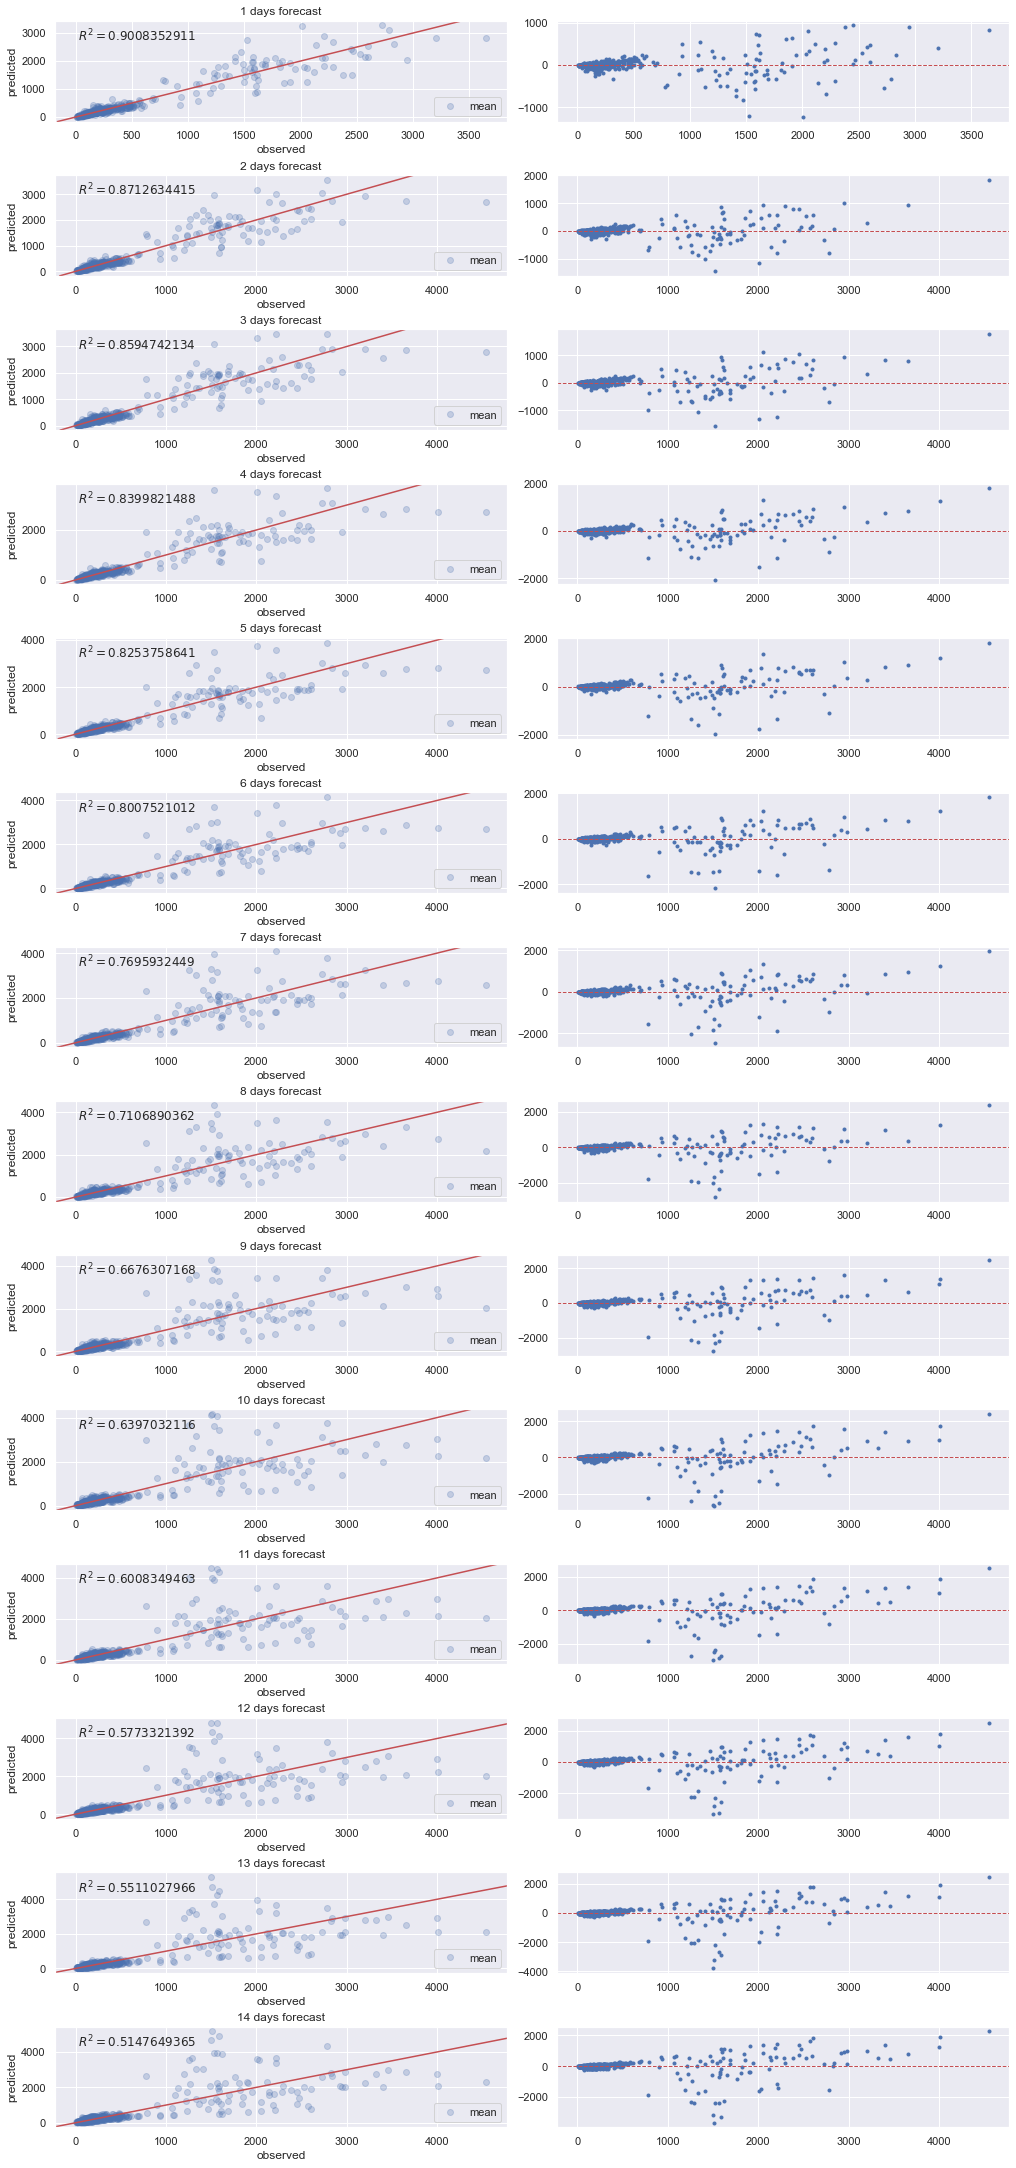

In [61]:
R2_days = {
    "day": [],
    "R2": []
}

fig, ax = plt.subplots(14, 2, constrained_layout=True, figsize=(14, 30))

for y in range(14):
    
    obs_y = observed[[x for x in range(y, observed.size, 14)]]
    for_y = forecasted[[x for x in range(y, observed.size, 14)]]

    R2 = r2_score(obs_y, for_y)
    R2_days["day"].append(y+1)
    R2_days["R2"].append(R2)

    ax1 = ax[y,0]
    ax2 = ax[y,1]

    ax1.plot(
        obs_y, for_y,
        marker='o', ls='none', alpha=.25, label='mean'
    )

    ax1.axline(xy1=(0, 0), slope=1, color='r')
    ax1.text(
        .05, .8,
        f"$R^2 = {R2:.10f}$",
        transform=ax1.transAxes
    )
    #ax1min = min(ax1.get_xlim()[0], ax1.get_ylim()[0])
    #ax1max = max(ax1.get_xlim()[1], ax1.get_ylim()[1])
    ax1.set(
        xlabel='observed',
        ylabel='predicted',
        title=f'{y+1} days forecast',
        #xlim=(ax1min, ax1max),
        #ylim=(ax1min, ax1max),
    )

    ax2.plot(obs_y, obs_y - for_y, ls='none', marker='.')
    ax2.axhline(0, color='r', lw=1, ls='--')

    ax1.legend(loc='lower right')

plt.show()

In [62]:
R2_days_df = pd.DataFrame(R2_days)

In [89]:
R2_days_df

,day,R2
0,1,0.900835
1,2,0.871263
2,3,0.859474
3,4,0.839982
4,5,0.825376
5,6,0.800752
6,7,0.769593
7,8,0.710689
8,9,0.667631
9,10,0.639703


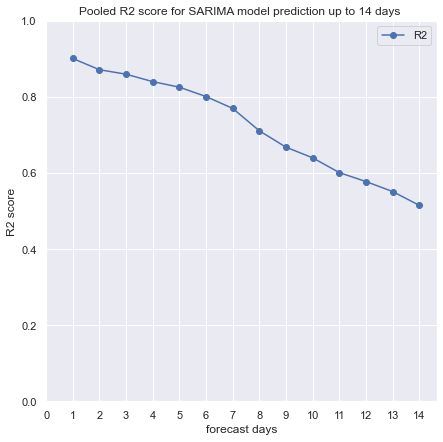

In [84]:
fig, ax = plt.subplots(figsize=(7,7))
R2_days_df.plot(x="day", y="R2", ax=ax, marker="o")
ax.set(
    ylim=(0,1),
    xticks=range(15),
    xlabel="forecast days",
    ylabel="R2 score",
    title="Pooled R2 score for SARIMA model prediction up to 14 days "
)

fname = "prediction_r2"
plt.savefig(
    f"{fname}.pdf",
    bbox_inches="tight", 
    #pad_inches=0.5
)
plt.savefig(
    f"{fname}.svg",
    bbox_inches="tight", 
    #pad_inches=0.5
)
plt.savefig(
    f"{fname}.png",
    bbox_inches="tight", 
    #pad_inches=0.5
)
plt.show()